In [30]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import math

In [31]:

train_data = datasets.CIFAR10(root="./data", download=True, train=True)
test_data = datasets.CIFAR10(root="./data", transform=transforms.ToTensor(), train=False)

Files already downloaded and verified


### Data augumentation

In [32]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __getitem__(self, index):
    return self.images[index], self.labels[index]
  
  def __len__(self):
    return len(self.labels)

In [33]:
def image_augumentation(dataset):
  transformed_images = []
  labels = []
  transform_list = [
      (transforms.RandomRotation(degrees=(0,180)), 5),
      (transforms.RandomHorizontalFlip(p=1), 1),
      (transforms.RandomVerticalFlip(p=1), 1),
      (transforms.ColorJitter(), 2),
      (transforms.RandomAffine(20), 2),
      (transforms.RandomPerspective(), 2),
      
  ]
  to_tensor = transforms.ToTensor()
  for i in range(len(train_data)):
    image, label = dataset[i]
    transformed_images.append(to_tensor(image))
    labels.append(label)
    # print(image)
    # transforms here
    for transform, count in transform_list:
      for _ in range(count):
        transformed_images.append(to_tensor(transform(image)))
        labels.append(label)
    print('done', i, "/", len(dataset))
  return transformed_images, labels

augumented_images = image_augumentation(train_data)
print(len(augumented_images))

done 0 / 50000
done 1 / 50000
done 2 / 50000
done 3 / 50000
done 4 / 50000
done 5 / 50000
done 6 / 50000
done 7 / 50000
done 8 / 50000
done 9 / 50000
done 10 / 50000
done 11 / 50000
done 12 / 50000
done 13 / 50000
done 14 / 50000
done 15 / 50000
done 16 / 50000
done 17 / 50000
done 18 / 50000
done 19 / 50000
done 20 / 50000
done 21 / 50000
done 22 / 50000
done 23 / 50000
done 24 / 50000
done 25 / 50000
done 26 / 50000
done 27 / 50000
done 28 / 50000
done 29 / 50000
done 30 / 50000
done 31 / 50000
done 32 / 50000
done 33 / 50000
done 34 / 50000
done 35 / 50000
done 36 / 50000
done 37 / 50000
done 38 / 50000
done 39 / 50000
done 40 / 50000
done 41 / 50000
done 42 / 50000
done 43 / 50000
done 44 / 50000
done 45 / 50000
done 46 / 50000
done 47 / 50000
done 48 / 50000
done 49 / 50000
done 50 / 50000
done 51 / 50000
done 52 / 50000
done 53 / 50000
done 54 / 50000
done 55 / 50000
done 56 / 50000
done 57 / 50000
done 58 / 50000
done 59 / 50000
done 60 / 50000
done 61 / 50000
done 62 / 50000
do

done 601 / 50000
done 602 / 50000
done 603 / 50000
done 604 / 50000
done 605 / 50000
done 606 / 50000
done 607 / 50000
done 608 / 50000
done 609 / 50000
done 610 / 50000
done 611 / 50000
done 612 / 50000
done 613 / 50000
done 614 / 50000
done 615 / 50000
done 616 / 50000
done 617 / 50000
done 618 / 50000
done 619 / 50000
done 620 / 50000
done 621 / 50000
done 622 / 50000
done 623 / 50000
done 624 / 50000
done 625 / 50000
done 626 / 50000
done 627 / 50000
done 628 / 50000
done 629 / 50000
done 630 / 50000
done 631 / 50000
done 632 / 50000
done 633 / 50000
done 634 / 50000
done 635 / 50000
done 636 / 50000
done 637 / 50000
done 638 / 50000
done 639 / 50000
done 640 / 50000
done 641 / 50000
done 642 / 50000
done 643 / 50000
done 644 / 50000
done 645 / 50000
done 646 / 50000
done 647 / 50000
done 648 / 50000
done 649 / 50000
done 650 / 50000
done 651 / 50000
done 652 / 50000
done 653 / 50000
done 654 / 50000
done 655 / 50000
done 656 / 50000
done 657 / 50000
done 658 / 50000
done 659 / 500

done 1082 / 50000
done 1083 / 50000
done 1084 / 50000
done 1085 / 50000
done 1086 / 50000
done 1087 / 50000
done 1088 / 50000
done 1089 / 50000
done 1090 / 50000
done 1091 / 50000
done 1092 / 50000
done 1093 / 50000
done 1094 / 50000
done 1095 / 50000
done 1096 / 50000
done 1097 / 50000
done 1098 / 50000
done 1099 / 50000
done 1100 / 50000
done 1101 / 50000
done 1102 / 50000
done 1103 / 50000
done 1104 / 50000
done 1105 / 50000
done 1106 / 50000
done 1107 / 50000
done 1108 / 50000
done 1109 / 50000
done 1110 / 50000
done 1111 / 50000
done 1112 / 50000
done 1113 / 50000
done 1114 / 50000
done 1115 / 50000
done 1116 / 50000
done 1117 / 50000
done 1118 / 50000
done 1119 / 50000
done 1120 / 50000
done 1121 / 50000
done 1122 / 50000
done 1123 / 50000
done 1124 / 50000
done 1125 / 50000
done 1126 / 50000
done 1127 / 50000
done 1128 / 50000
done 1129 / 50000
done 1130 / 50000
done 1131 / 50000
done 1132 / 50000
done 1133 / 50000
done 1134 / 50000
done 1135 / 50000
done 1136 / 50000
done 1137 

done 1552 / 50000
done 1553 / 50000
done 1554 / 50000
done 1555 / 50000
done 1556 / 50000
done 1557 / 50000
done 1558 / 50000
done 1559 / 50000
done 1560 / 50000
done 1561 / 50000
done 1562 / 50000
done 1563 / 50000
done 1564 / 50000
done 1565 / 50000
done 1566 / 50000
done 1567 / 50000
done 1568 / 50000
done 1569 / 50000
done 1570 / 50000
done 1571 / 50000
done 1572 / 50000
done 1573 / 50000
done 1574 / 50000
done 1575 / 50000
done 1576 / 50000
done 1577 / 50000
done 1578 / 50000
done 1579 / 50000
done 1580 / 50000
done 1581 / 50000
done 1582 / 50000
done 1583 / 50000
done 1584 / 50000
done 1585 / 50000
done 1586 / 50000
done 1587 / 50000
done 1588 / 50000
done 1589 / 50000
done 1590 / 50000
done 1591 / 50000
done 1592 / 50000
done 1593 / 50000
done 1594 / 50000
done 1595 / 50000
done 1596 / 50000
done 1597 / 50000
done 1598 / 50000
done 1599 / 50000
done 1600 / 50000
done 1601 / 50000
done 1602 / 50000
done 1603 / 50000
done 1604 / 50000
done 1605 / 50000
done 1606 / 50000
done 1607 

done 2027 / 50000
done 2028 / 50000
done 2029 / 50000
done 2030 / 50000
done 2031 / 50000
done 2032 / 50000
done 2033 / 50000
done 2034 / 50000
done 2035 / 50000
done 2036 / 50000
done 2037 / 50000
done 2038 / 50000
done 2039 / 50000
done 2040 / 50000
done 2041 / 50000
done 2042 / 50000
done 2043 / 50000
done 2044 / 50000
done 2045 / 50000
done 2046 / 50000
done 2047 / 50000
done 2048 / 50000
done 2049 / 50000
done 2050 / 50000
done 2051 / 50000
done 2052 / 50000
done 2053 / 50000
done 2054 / 50000
done 2055 / 50000
done 2056 / 50000
done 2057 / 50000
done 2058 / 50000
done 2059 / 50000
done 2060 / 50000
done 2061 / 50000
done 2062 / 50000
done 2063 / 50000
done 2064 / 50000
done 2065 / 50000
done 2066 / 50000
done 2067 / 50000
done 2068 / 50000
done 2069 / 50000
done 2070 / 50000
done 2071 / 50000
done 2072 / 50000
done 2073 / 50000
done 2074 / 50000
done 2075 / 50000
done 2076 / 50000
done 2077 / 50000
done 2078 / 50000
done 2079 / 50000
done 2080 / 50000
done 2081 / 50000
done 2082 

done 2503 / 50000
done 2504 / 50000
done 2505 / 50000
done 2506 / 50000
done 2507 / 50000
done 2508 / 50000
done 2509 / 50000
done 2510 / 50000
done 2511 / 50000
done 2512 / 50000
done 2513 / 50000
done 2514 / 50000
done 2515 / 50000
done 2516 / 50000
done 2517 / 50000
done 2518 / 50000
done 2519 / 50000
done 2520 / 50000
done 2521 / 50000
done 2522 / 50000
done 2523 / 50000
done 2524 / 50000
done 2525 / 50000
done 2526 / 50000
done 2527 / 50000
done 2528 / 50000
done 2529 / 50000
done 2530 / 50000
done 2531 / 50000
done 2532 / 50000
done 2533 / 50000
done 2534 / 50000
done 2535 / 50000
done 2536 / 50000
done 2537 / 50000
done 2538 / 50000
done 2539 / 50000
done 2540 / 50000
done 2541 / 50000
done 2542 / 50000
done 2543 / 50000
done 2544 / 50000
done 2545 / 50000
done 2546 / 50000
done 2547 / 50000
done 2548 / 50000
done 2549 / 50000
done 2550 / 50000
done 2551 / 50000
done 2552 / 50000
done 2553 / 50000
done 2554 / 50000
done 2555 / 50000
done 2556 / 50000
done 2557 / 50000
done 2558 

done 2976 / 50000
done 2977 / 50000
done 2978 / 50000
done 2979 / 50000
done 2980 / 50000
done 2981 / 50000
done 2982 / 50000
done 2983 / 50000
done 2984 / 50000
done 2985 / 50000
done 2986 / 50000
done 2987 / 50000
done 2988 / 50000
done 2989 / 50000
done 2990 / 50000
done 2991 / 50000
done 2992 / 50000
done 2993 / 50000
done 2994 / 50000
done 2995 / 50000
done 2996 / 50000
done 2997 / 50000
done 2998 / 50000
done 2999 / 50000
done 3000 / 50000
done 3001 / 50000
done 3002 / 50000
done 3003 / 50000
done 3004 / 50000
done 3005 / 50000
done 3006 / 50000
done 3007 / 50000
done 3008 / 50000
done 3009 / 50000
done 3010 / 50000
done 3011 / 50000
done 3012 / 50000
done 3013 / 50000
done 3014 / 50000
done 3015 / 50000
done 3016 / 50000
done 3017 / 50000
done 3018 / 50000
done 3019 / 50000
done 3020 / 50000
done 3021 / 50000
done 3022 / 50000
done 3023 / 50000
done 3024 / 50000
done 3025 / 50000
done 3026 / 50000
done 3027 / 50000
done 3028 / 50000
done 3029 / 50000
done 3030 / 50000
done 3031 

done 3450 / 50000
done 3451 / 50000
done 3452 / 50000
done 3453 / 50000
done 3454 / 50000
done 3455 / 50000
done 3456 / 50000
done 3457 / 50000
done 3458 / 50000
done 3459 / 50000
done 3460 / 50000
done 3461 / 50000
done 3462 / 50000
done 3463 / 50000
done 3464 / 50000
done 3465 / 50000
done 3466 / 50000
done 3467 / 50000
done 3468 / 50000
done 3469 / 50000
done 3470 / 50000
done 3471 / 50000
done 3472 / 50000
done 3473 / 50000
done 3474 / 50000
done 3475 / 50000
done 3476 / 50000
done 3477 / 50000
done 3478 / 50000
done 3479 / 50000
done 3480 / 50000
done 3481 / 50000
done 3482 / 50000
done 3483 / 50000
done 3484 / 50000
done 3485 / 50000
done 3486 / 50000
done 3487 / 50000
done 3488 / 50000
done 3489 / 50000
done 3490 / 50000
done 3491 / 50000
done 3492 / 50000
done 3493 / 50000
done 3494 / 50000
done 3495 / 50000
done 3496 / 50000
done 3497 / 50000
done 3498 / 50000
done 3499 / 50000
done 3500 / 50000
done 3501 / 50000
done 3502 / 50000
done 3503 / 50000
done 3504 / 50000
done 3505 

done 3926 / 50000
done 3927 / 50000
done 3928 / 50000
done 3929 / 50000
done 3930 / 50000
done 3931 / 50000
done 3932 / 50000
done 3933 / 50000
done 3934 / 50000
done 3935 / 50000
done 3936 / 50000
done 3937 / 50000
done 3938 / 50000
done 3939 / 50000
done 3940 / 50000
done 3941 / 50000
done 3942 / 50000
done 3943 / 50000
done 3944 / 50000
done 3945 / 50000
done 3946 / 50000
done 3947 / 50000
done 3948 / 50000
done 3949 / 50000
done 3950 / 50000
done 3951 / 50000
done 3952 / 50000
done 3953 / 50000
done 3954 / 50000
done 3955 / 50000
done 3956 / 50000
done 3957 / 50000
done 3958 / 50000
done 3959 / 50000
done 3960 / 50000
done 3961 / 50000
done 3962 / 50000
done 3963 / 50000
done 3964 / 50000
done 3965 / 50000
done 3966 / 50000
done 3967 / 50000
done 3968 / 50000
done 3969 / 50000
done 3970 / 50000
done 3971 / 50000
done 3972 / 50000
done 3973 / 50000
done 3974 / 50000
done 3975 / 50000
done 3976 / 50000
done 3977 / 50000
done 3978 / 50000
done 3979 / 50000
done 3980 / 50000
done 3981 

done 4401 / 50000
done 4402 / 50000
done 4403 / 50000
done 4404 / 50000
done 4405 / 50000
done 4406 / 50000
done 4407 / 50000
done 4408 / 50000
done 4409 / 50000
done 4410 / 50000
done 4411 / 50000
done 4412 / 50000
done 4413 / 50000
done 4414 / 50000
done 4415 / 50000
done 4416 / 50000
done 4417 / 50000
done 4418 / 50000
done 4419 / 50000
done 4420 / 50000
done 4421 / 50000
done 4422 / 50000
done 4423 / 50000
done 4424 / 50000
done 4425 / 50000
done 4426 / 50000
done 4427 / 50000
done 4428 / 50000
done 4429 / 50000
done 4430 / 50000
done 4431 / 50000
done 4432 / 50000
done 4433 / 50000
done 4434 / 50000
done 4435 / 50000
done 4436 / 50000
done 4437 / 50000
done 4438 / 50000
done 4439 / 50000
done 4440 / 50000
done 4441 / 50000
done 4442 / 50000
done 4443 / 50000
done 4444 / 50000
done 4445 / 50000
done 4446 / 50000
done 4447 / 50000
done 4448 / 50000
done 4449 / 50000
done 4450 / 50000
done 4451 / 50000
done 4452 / 50000
done 4453 / 50000
done 4454 / 50000
done 4455 / 50000
done 4456 

done 4872 / 50000
done 4873 / 50000
done 4874 / 50000
done 4875 / 50000
done 4876 / 50000
done 4877 / 50000
done 4878 / 50000
done 4879 / 50000
done 4880 / 50000
done 4881 / 50000
done 4882 / 50000
done 4883 / 50000
done 4884 / 50000
done 4885 / 50000
done 4886 / 50000
done 4887 / 50000
done 4888 / 50000
done 4889 / 50000
done 4890 / 50000
done 4891 / 50000
done 4892 / 50000
done 4893 / 50000
done 4894 / 50000
done 4895 / 50000
done 4896 / 50000
done 4897 / 50000
done 4898 / 50000
done 4899 / 50000
done 4900 / 50000
done 4901 / 50000
done 4902 / 50000
done 4903 / 50000
done 4904 / 50000
done 4905 / 50000
done 4906 / 50000
done 4907 / 50000
done 4908 / 50000
done 4909 / 50000
done 4910 / 50000
done 4911 / 50000
done 4912 / 50000
done 4913 / 50000
done 4914 / 50000
done 4915 / 50000
done 4916 / 50000
done 4917 / 50000
done 4918 / 50000
done 4919 / 50000
done 4920 / 50000
done 4921 / 50000
done 4922 / 50000
done 4923 / 50000
done 4924 / 50000
done 4925 / 50000
done 4926 / 50000
done 4927 

done 5350 / 50000
done 5351 / 50000
done 5352 / 50000
done 5353 / 50000
done 5354 / 50000
done 5355 / 50000
done 5356 / 50000
done 5357 / 50000
done 5358 / 50000
done 5359 / 50000
done 5360 / 50000
done 5361 / 50000
done 5362 / 50000
done 5363 / 50000
done 5364 / 50000
done 5365 / 50000
done 5366 / 50000
done 5367 / 50000
done 5368 / 50000
done 5369 / 50000
done 5370 / 50000
done 5371 / 50000
done 5372 / 50000
done 5373 / 50000
done 5374 / 50000
done 5375 / 50000
done 5376 / 50000
done 5377 / 50000
done 5378 / 50000
done 5379 / 50000
done 5380 / 50000
done 5381 / 50000
done 5382 / 50000
done 5383 / 50000
done 5384 / 50000
done 5385 / 50000
done 5386 / 50000
done 5387 / 50000
done 5388 / 50000
done 5389 / 50000
done 5390 / 50000
done 5391 / 50000
done 5392 / 50000
done 5393 / 50000
done 5394 / 50000
done 5395 / 50000
done 5396 / 50000
done 5397 / 50000
done 5398 / 50000
done 5399 / 50000
done 5400 / 50000
done 5401 / 50000
done 5402 / 50000
done 5403 / 50000
done 5404 / 50000
done 5405 

done 5826 / 50000
done 5827 / 50000
done 5828 / 50000
done 5829 / 50000
done 5830 / 50000
done 5831 / 50000
done 5832 / 50000
done 5833 / 50000
done 5834 / 50000
done 5835 / 50000
done 5836 / 50000
done 5837 / 50000
done 5838 / 50000
done 5839 / 50000
done 5840 / 50000
done 5841 / 50000
done 5842 / 50000
done 5843 / 50000
done 5844 / 50000
done 5845 / 50000
done 5846 / 50000
done 5847 / 50000
done 5848 / 50000
done 5849 / 50000
done 5850 / 50000
done 5851 / 50000
done 5852 / 50000
done 5853 / 50000
done 5854 / 50000
done 5855 / 50000
done 5856 / 50000
done 5857 / 50000
done 5858 / 50000
done 5859 / 50000
done 5860 / 50000
done 5861 / 50000
done 5862 / 50000
done 5863 / 50000
done 5864 / 50000
done 5865 / 50000
done 5866 / 50000
done 5867 / 50000
done 5868 / 50000
done 5869 / 50000
done 5870 / 50000
done 5871 / 50000
done 5872 / 50000
done 5873 / 50000
done 5874 / 50000
done 5875 / 50000
done 5876 / 50000
done 5877 / 50000
done 5878 / 50000
done 5879 / 50000
done 5880 / 50000
done 5881 

done 6293 / 50000
done 6294 / 50000
done 6295 / 50000
done 6296 / 50000
done 6297 / 50000
done 6298 / 50000
done 6299 / 50000
done 6300 / 50000
done 6301 / 50000
done 6302 / 50000
done 6303 / 50000
done 6304 / 50000
done 6305 / 50000
done 6306 / 50000
done 6307 / 50000
done 6308 / 50000
done 6309 / 50000
done 6310 / 50000
done 6311 / 50000
done 6312 / 50000
done 6313 / 50000
done 6314 / 50000
done 6315 / 50000
done 6316 / 50000
done 6317 / 50000
done 6318 / 50000
done 6319 / 50000
done 6320 / 50000
done 6321 / 50000
done 6322 / 50000
done 6323 / 50000
done 6324 / 50000
done 6325 / 50000
done 6326 / 50000
done 6327 / 50000
done 6328 / 50000
done 6329 / 50000
done 6330 / 50000
done 6331 / 50000
done 6332 / 50000
done 6333 / 50000
done 6334 / 50000
done 6335 / 50000
done 6336 / 50000
done 6337 / 50000
done 6338 / 50000
done 6339 / 50000
done 6340 / 50000
done 6341 / 50000
done 6342 / 50000
done 6343 / 50000
done 6344 / 50000
done 6345 / 50000
done 6346 / 50000
done 6347 / 50000
done 6348 

done 6762 / 50000
done 6763 / 50000
done 6764 / 50000
done 6765 / 50000
done 6766 / 50000
done 6767 / 50000
done 6768 / 50000
done 6769 / 50000
done 6770 / 50000
done 6771 / 50000
done 6772 / 50000
done 6773 / 50000
done 6774 / 50000
done 6775 / 50000
done 6776 / 50000
done 6777 / 50000
done 6778 / 50000
done 6779 / 50000
done 6780 / 50000
done 6781 / 50000
done 6782 / 50000
done 6783 / 50000
done 6784 / 50000
done 6785 / 50000
done 6786 / 50000
done 6787 / 50000
done 6788 / 50000
done 6789 / 50000
done 6790 / 50000
done 6791 / 50000
done 6792 / 50000
done 6793 / 50000
done 6794 / 50000
done 6795 / 50000
done 6796 / 50000
done 6797 / 50000
done 6798 / 50000
done 6799 / 50000
done 6800 / 50000
done 6801 / 50000
done 6802 / 50000
done 6803 / 50000
done 6804 / 50000
done 6805 / 50000
done 6806 / 50000
done 6807 / 50000
done 6808 / 50000
done 6809 / 50000
done 6810 / 50000
done 6811 / 50000
done 6812 / 50000
done 6813 / 50000
done 6814 / 50000
done 6815 / 50000
done 6816 / 50000
done 6817 

done 7230 / 50000
done 7231 / 50000
done 7232 / 50000
done 7233 / 50000
done 7234 / 50000
done 7235 / 50000
done 7236 / 50000
done 7237 / 50000
done 7238 / 50000
done 7239 / 50000
done 7240 / 50000
done 7241 / 50000
done 7242 / 50000
done 7243 / 50000
done 7244 / 50000
done 7245 / 50000
done 7246 / 50000
done 7247 / 50000
done 7248 / 50000
done 7249 / 50000
done 7250 / 50000
done 7251 / 50000
done 7252 / 50000
done 7253 / 50000
done 7254 / 50000
done 7255 / 50000
done 7256 / 50000
done 7257 / 50000
done 7258 / 50000
done 7259 / 50000
done 7260 / 50000
done 7261 / 50000
done 7262 / 50000
done 7263 / 50000
done 7264 / 50000
done 7265 / 50000
done 7266 / 50000
done 7267 / 50000
done 7268 / 50000
done 7269 / 50000
done 7270 / 50000
done 7271 / 50000
done 7272 / 50000
done 7273 / 50000
done 7274 / 50000
done 7275 / 50000
done 7276 / 50000
done 7277 / 50000
done 7278 / 50000
done 7279 / 50000
done 7280 / 50000
done 7281 / 50000
done 7282 / 50000
done 7283 / 50000
done 7284 / 50000
done 7285 

done 7700 / 50000
done 7701 / 50000
done 7702 / 50000
done 7703 / 50000
done 7704 / 50000
done 7705 / 50000
done 7706 / 50000
done 7707 / 50000
done 7708 / 50000
done 7709 / 50000
done 7710 / 50000
done 7711 / 50000
done 7712 / 50000
done 7713 / 50000
done 7714 / 50000
done 7715 / 50000
done 7716 / 50000
done 7717 / 50000
done 7718 / 50000
done 7719 / 50000
done 7720 / 50000
done 7721 / 50000
done 7722 / 50000
done 7723 / 50000
done 7724 / 50000
done 7725 / 50000
done 7726 / 50000
done 7727 / 50000
done 7728 / 50000
done 7729 / 50000
done 7730 / 50000
done 7731 / 50000
done 7732 / 50000
done 7733 / 50000
done 7734 / 50000
done 7735 / 50000
done 7736 / 50000
done 7737 / 50000
done 7738 / 50000
done 7739 / 50000
done 7740 / 50000
done 7741 / 50000
done 7742 / 50000
done 7743 / 50000
done 7744 / 50000
done 7745 / 50000
done 7746 / 50000
done 7747 / 50000
done 7748 / 50000
done 7749 / 50000
done 7750 / 50000
done 7751 / 50000
done 7752 / 50000
done 7753 / 50000
done 7754 / 50000
done 7755 

done 8166 / 50000
done 8167 / 50000
done 8168 / 50000
done 8169 / 50000
done 8170 / 50000
done 8171 / 50000
done 8172 / 50000
done 8173 / 50000
done 8174 / 50000
done 8175 / 50000
done 8176 / 50000
done 8177 / 50000
done 8178 / 50000
done 8179 / 50000
done 8180 / 50000
done 8181 / 50000
done 8182 / 50000
done 8183 / 50000
done 8184 / 50000
done 8185 / 50000
done 8186 / 50000
done 8187 / 50000
done 8188 / 50000
done 8189 / 50000
done 8190 / 50000
done 8191 / 50000
done 8192 / 50000
done 8193 / 50000
done 8194 / 50000
done 8195 / 50000
done 8196 / 50000
done 8197 / 50000
done 8198 / 50000
done 8199 / 50000
done 8200 / 50000
done 8201 / 50000
done 8202 / 50000
done 8203 / 50000
done 8204 / 50000
done 8205 / 50000
done 8206 / 50000
done 8207 / 50000
done 8208 / 50000
done 8209 / 50000
done 8210 / 50000
done 8211 / 50000
done 8212 / 50000
done 8213 / 50000
done 8214 / 50000
done 8215 / 50000
done 8216 / 50000
done 8217 / 50000
done 8218 / 50000
done 8219 / 50000
done 8220 / 50000
done 8221 

done 8632 / 50000
done 8633 / 50000
done 8634 / 50000
done 8635 / 50000
done 8636 / 50000
done 8637 / 50000
done 8638 / 50000
done 8639 / 50000
done 8640 / 50000
done 8641 / 50000
done 8642 / 50000
done 8643 / 50000
done 8644 / 50000
done 8645 / 50000
done 8646 / 50000
done 8647 / 50000
done 8648 / 50000
done 8649 / 50000
done 8650 / 50000
done 8651 / 50000
done 8652 / 50000
done 8653 / 50000
done 8654 / 50000
done 8655 / 50000
done 8656 / 50000
done 8657 / 50000
done 8658 / 50000
done 8659 / 50000
done 8660 / 50000
done 8661 / 50000
done 8662 / 50000
done 8663 / 50000
done 8664 / 50000
done 8665 / 50000
done 8666 / 50000
done 8667 / 50000
done 8668 / 50000
done 8669 / 50000
done 8670 / 50000
done 8671 / 50000
done 8672 / 50000
done 8673 / 50000
done 8674 / 50000
done 8675 / 50000
done 8676 / 50000
done 8677 / 50000
done 8678 / 50000
done 8679 / 50000
done 8680 / 50000
done 8681 / 50000
done 8682 / 50000
done 8683 / 50000
done 8684 / 50000
done 8685 / 50000
done 8686 / 50000
done 8687 

done 9101 / 50000
done 9102 / 50000
done 9103 / 50000
done 9104 / 50000
done 9105 / 50000
done 9106 / 50000
done 9107 / 50000
done 9108 / 50000
done 9109 / 50000
done 9110 / 50000
done 9111 / 50000
done 9112 / 50000
done 9113 / 50000
done 9114 / 50000
done 9115 / 50000
done 9116 / 50000
done 9117 / 50000
done 9118 / 50000
done 9119 / 50000
done 9120 / 50000
done 9121 / 50000
done 9122 / 50000
done 9123 / 50000
done 9124 / 50000
done 9125 / 50000
done 9126 / 50000
done 9127 / 50000
done 9128 / 50000
done 9129 / 50000
done 9130 / 50000
done 9131 / 50000
done 9132 / 50000
done 9133 / 50000
done 9134 / 50000
done 9135 / 50000
done 9136 / 50000
done 9137 / 50000
done 9138 / 50000
done 9139 / 50000
done 9140 / 50000
done 9141 / 50000
done 9142 / 50000
done 9143 / 50000
done 9144 / 50000
done 9145 / 50000
done 9146 / 50000
done 9147 / 50000
done 9148 / 50000
done 9149 / 50000
done 9150 / 50000
done 9151 / 50000
done 9152 / 50000
done 9153 / 50000
done 9154 / 50000
done 9155 / 50000
done 9156 

done 9569 / 50000
done 9570 / 50000
done 9571 / 50000
done 9572 / 50000
done 9573 / 50000
done 9574 / 50000
done 9575 / 50000
done 9576 / 50000
done 9577 / 50000
done 9578 / 50000
done 9579 / 50000
done 9580 / 50000
done 9581 / 50000
done 9582 / 50000
done 9583 / 50000
done 9584 / 50000
done 9585 / 50000
done 9586 / 50000
done 9587 / 50000
done 9588 / 50000
done 9589 / 50000
done 9590 / 50000
done 9591 / 50000
done 9592 / 50000
done 9593 / 50000
done 9594 / 50000
done 9595 / 50000
done 9596 / 50000
done 9597 / 50000
done 9598 / 50000
done 9599 / 50000
done 9600 / 50000
done 9601 / 50000
done 9602 / 50000
done 9603 / 50000
done 9604 / 50000
done 9605 / 50000
done 9606 / 50000
done 9607 / 50000
done 9608 / 50000
done 9609 / 50000
done 9610 / 50000
done 9611 / 50000
done 9612 / 50000
done 9613 / 50000
done 9614 / 50000
done 9615 / 50000
done 9616 / 50000
done 9617 / 50000
done 9618 / 50000
done 9619 / 50000
done 9620 / 50000
done 9621 / 50000
done 9622 / 50000
done 9623 / 50000
done 9624 

done 10032 / 50000
done 10033 / 50000
done 10034 / 50000
done 10035 / 50000
done 10036 / 50000
done 10037 / 50000
done 10038 / 50000
done 10039 / 50000
done 10040 / 50000
done 10041 / 50000
done 10042 / 50000
done 10043 / 50000
done 10044 / 50000
done 10045 / 50000
done 10046 / 50000
done 10047 / 50000
done 10048 / 50000
done 10049 / 50000
done 10050 / 50000
done 10051 / 50000
done 10052 / 50000
done 10053 / 50000
done 10054 / 50000
done 10055 / 50000
done 10056 / 50000
done 10057 / 50000
done 10058 / 50000
done 10059 / 50000
done 10060 / 50000
done 10061 / 50000
done 10062 / 50000
done 10063 / 50000
done 10064 / 50000
done 10065 / 50000
done 10066 / 50000
done 10067 / 50000
done 10068 / 50000
done 10069 / 50000
done 10070 / 50000
done 10071 / 50000
done 10072 / 50000
done 10073 / 50000
done 10074 / 50000
done 10075 / 50000
done 10076 / 50000
done 10077 / 50000
done 10078 / 50000
done 10079 / 50000
done 10080 / 50000
done 10081 / 50000
done 10082 / 50000
done 10083 / 50000
done 10084 /

done 10496 / 50000
done 10497 / 50000
done 10498 / 50000
done 10499 / 50000
done 10500 / 50000
done 10501 / 50000
done 10502 / 50000
done 10503 / 50000
done 10504 / 50000
done 10505 / 50000
done 10506 / 50000
done 10507 / 50000
done 10508 / 50000
done 10509 / 50000
done 10510 / 50000
done 10511 / 50000
done 10512 / 50000
done 10513 / 50000
done 10514 / 50000
done 10515 / 50000
done 10516 / 50000
done 10517 / 50000
done 10518 / 50000
done 10519 / 50000
done 10520 / 50000
done 10521 / 50000
done 10522 / 50000
done 10523 / 50000
done 10524 / 50000
done 10525 / 50000
done 10526 / 50000
done 10527 / 50000
done 10528 / 50000
done 10529 / 50000
done 10530 / 50000
done 10531 / 50000
done 10532 / 50000
done 10533 / 50000
done 10534 / 50000
done 10535 / 50000
done 10536 / 50000
done 10537 / 50000
done 10538 / 50000
done 10539 / 50000
done 10540 / 50000
done 10541 / 50000
done 10542 / 50000
done 10543 / 50000
done 10544 / 50000
done 10545 / 50000
done 10546 / 50000
done 10547 / 50000
done 10548 /

done 10961 / 50000
done 10962 / 50000
done 10963 / 50000
done 10964 / 50000
done 10965 / 50000
done 10966 / 50000
done 10967 / 50000
done 10968 / 50000
done 10969 / 50000
done 10970 / 50000
done 10971 / 50000
done 10972 / 50000
done 10973 / 50000
done 10974 / 50000
done 10975 / 50000
done 10976 / 50000
done 10977 / 50000
done 10978 / 50000
done 10979 / 50000
done 10980 / 50000
done 10981 / 50000
done 10982 / 50000
done 10983 / 50000
done 10984 / 50000
done 10985 / 50000
done 10986 / 50000
done 10987 / 50000
done 10988 / 50000
done 10989 / 50000
done 10990 / 50000
done 10991 / 50000
done 10992 / 50000
done 10993 / 50000
done 10994 / 50000
done 10995 / 50000
done 10996 / 50000
done 10997 / 50000
done 10998 / 50000
done 10999 / 50000
done 11000 / 50000
done 11001 / 50000
done 11002 / 50000
done 11003 / 50000
done 11004 / 50000
done 11005 / 50000
done 11006 / 50000
done 11007 / 50000
done 11008 / 50000
done 11009 / 50000
done 11010 / 50000
done 11011 / 50000
done 11012 / 50000
done 11013 /

done 11422 / 50000
done 11423 / 50000
done 11424 / 50000
done 11425 / 50000
done 11426 / 50000
done 11427 / 50000
done 11428 / 50000
done 11429 / 50000
done 11430 / 50000
done 11431 / 50000
done 11432 / 50000
done 11433 / 50000
done 11434 / 50000
done 11435 / 50000
done 11436 / 50000
done 11437 / 50000
done 11438 / 50000
done 11439 / 50000
done 11440 / 50000
done 11441 / 50000
done 11442 / 50000
done 11443 / 50000
done 11444 / 50000
done 11445 / 50000
done 11446 / 50000
done 11447 / 50000
done 11448 / 50000
done 11449 / 50000
done 11450 / 50000
done 11451 / 50000
done 11452 / 50000
done 11453 / 50000
done 11454 / 50000
done 11455 / 50000
done 11456 / 50000
done 11457 / 50000
done 11458 / 50000
done 11459 / 50000
done 11460 / 50000
done 11461 / 50000
done 11462 / 50000
done 11463 / 50000
done 11464 / 50000
done 11465 / 50000
done 11466 / 50000
done 11467 / 50000
done 11468 / 50000
done 11469 / 50000
done 11470 / 50000
done 11471 / 50000
done 11472 / 50000
done 11473 / 50000
done 11474 /

done 11874 / 50000
done 11875 / 50000
done 11876 / 50000
done 11877 / 50000
done 11878 / 50000
done 11879 / 50000
done 11880 / 50000
done 11881 / 50000
done 11882 / 50000
done 11883 / 50000
done 11884 / 50000
done 11885 / 50000
done 11886 / 50000
done 11887 / 50000
done 11888 / 50000
done 11889 / 50000
done 11890 / 50000
done 11891 / 50000
done 11892 / 50000
done 11893 / 50000
done 11894 / 50000
done 11895 / 50000
done 11896 / 50000
done 11897 / 50000
done 11898 / 50000
done 11899 / 50000
done 11900 / 50000
done 11901 / 50000
done 11902 / 50000
done 11903 / 50000
done 11904 / 50000
done 11905 / 50000
done 11906 / 50000
done 11907 / 50000
done 11908 / 50000
done 11909 / 50000
done 11910 / 50000
done 11911 / 50000
done 11912 / 50000
done 11913 / 50000
done 11914 / 50000
done 11915 / 50000
done 11916 / 50000
done 11917 / 50000
done 11918 / 50000
done 11919 / 50000
done 11920 / 50000
done 11921 / 50000
done 11922 / 50000
done 11923 / 50000
done 11924 / 50000
done 11925 / 50000
done 11926 /

done 12317 / 50000
done 12318 / 50000
done 12319 / 50000
done 12320 / 50000
done 12321 / 50000
done 12322 / 50000
done 12323 / 50000
done 12324 / 50000
done 12325 / 50000
done 12326 / 50000
done 12327 / 50000
done 12328 / 50000
done 12329 / 50000
done 12330 / 50000
done 12331 / 50000
done 12332 / 50000
done 12333 / 50000
done 12334 / 50000
done 12335 / 50000
done 12336 / 50000
done 12337 / 50000
done 12338 / 50000
done 12339 / 50000
done 12340 / 50000
done 12341 / 50000
done 12342 / 50000
done 12343 / 50000
done 12344 / 50000
done 12345 / 50000
done 12346 / 50000
done 12347 / 50000
done 12348 / 50000
done 12349 / 50000
done 12350 / 50000
done 12351 / 50000
done 12352 / 50000
done 12353 / 50000
done 12354 / 50000
done 12355 / 50000
done 12356 / 50000
done 12357 / 50000
done 12358 / 50000
done 12359 / 50000
done 12360 / 50000
done 12361 / 50000
done 12362 / 50000
done 12363 / 50000
done 12364 / 50000
done 12365 / 50000
done 12366 / 50000
done 12367 / 50000
done 12368 / 50000
done 12369 /

done 12760 / 50000
done 12761 / 50000
done 12762 / 50000
done 12763 / 50000
done 12764 / 50000
done 12765 / 50000
done 12766 / 50000
done 12767 / 50000
done 12768 / 50000
done 12769 / 50000
done 12770 / 50000
done 12771 / 50000
done 12772 / 50000
done 12773 / 50000
done 12774 / 50000
done 12775 / 50000
done 12776 / 50000
done 12777 / 50000
done 12778 / 50000
done 12779 / 50000
done 12780 / 50000
done 12781 / 50000
done 12782 / 50000
done 12783 / 50000
done 12784 / 50000
done 12785 / 50000
done 12786 / 50000
done 12787 / 50000
done 12788 / 50000
done 12789 / 50000
done 12790 / 50000
done 12791 / 50000
done 12792 / 50000
done 12793 / 50000
done 12794 / 50000
done 12795 / 50000
done 12796 / 50000
done 12797 / 50000
done 12798 / 50000
done 12799 / 50000
done 12800 / 50000
done 12801 / 50000
done 12802 / 50000
done 12803 / 50000
done 12804 / 50000
done 12805 / 50000
done 12806 / 50000
done 12807 / 50000
done 12808 / 50000
done 12809 / 50000
done 12810 / 50000
done 12811 / 50000
done 12812 /

done 13214 / 50000
done 13215 / 50000
done 13216 / 50000
done 13217 / 50000
done 13218 / 50000
done 13219 / 50000
done 13220 / 50000
done 13221 / 50000
done 13222 / 50000
done 13223 / 50000
done 13224 / 50000
done 13225 / 50000
done 13226 / 50000
done 13227 / 50000
done 13228 / 50000
done 13229 / 50000
done 13230 / 50000
done 13231 / 50000
done 13232 / 50000
done 13233 / 50000
done 13234 / 50000
done 13235 / 50000
done 13236 / 50000
done 13237 / 50000
done 13238 / 50000
done 13239 / 50000
done 13240 / 50000
done 13241 / 50000
done 13242 / 50000
done 13243 / 50000
done 13244 / 50000
done 13245 / 50000
done 13246 / 50000
done 13247 / 50000
done 13248 / 50000
done 13249 / 50000
done 13250 / 50000
done 13251 / 50000
done 13252 / 50000
done 13253 / 50000
done 13254 / 50000
done 13255 / 50000
done 13256 / 50000
done 13257 / 50000
done 13258 / 50000
done 13259 / 50000
done 13260 / 50000
done 13261 / 50000
done 13262 / 50000
done 13263 / 50000
done 13264 / 50000
done 13265 / 50000
done 13266 /

done 13718 / 50000
done 13719 / 50000
done 13720 / 50000
done 13721 / 50000
done 13722 / 50000
done 13723 / 50000
done 13724 / 50000
done 13725 / 50000
done 13726 / 50000
done 13727 / 50000
done 13728 / 50000
done 13729 / 50000
done 13730 / 50000
done 13731 / 50000
done 13732 / 50000
done 13733 / 50000
done 13734 / 50000
done 13735 / 50000
done 13736 / 50000
done 13737 / 50000
done 13738 / 50000
done 13739 / 50000
done 13740 / 50000
done 13741 / 50000
done 13742 / 50000
done 13743 / 50000
done 13744 / 50000
done 13745 / 50000
done 13746 / 50000
done 13747 / 50000
done 13748 / 50000
done 13749 / 50000
done 13750 / 50000
done 13751 / 50000
done 13752 / 50000
done 13753 / 50000
done 13754 / 50000
done 13755 / 50000
done 13756 / 50000
done 13757 / 50000
done 13758 / 50000
done 13759 / 50000
done 13760 / 50000
done 13761 / 50000
done 13762 / 50000
done 13763 / 50000
done 13764 / 50000
done 13765 / 50000
done 13766 / 50000
done 13767 / 50000
done 13768 / 50000
done 13769 / 50000
done 13770 /

done 14178 / 50000
done 14179 / 50000
done 14180 / 50000
done 14181 / 50000
done 14182 / 50000
done 14183 / 50000
done 14184 / 50000
done 14185 / 50000
done 14186 / 50000
done 14187 / 50000
done 14188 / 50000
done 14189 / 50000
done 14190 / 50000
done 14191 / 50000
done 14192 / 50000
done 14193 / 50000
done 14194 / 50000
done 14195 / 50000
done 14196 / 50000
done 14197 / 50000
done 14198 / 50000
done 14199 / 50000
done 14200 / 50000
done 14201 / 50000
done 14202 / 50000
done 14203 / 50000
done 14204 / 50000
done 14205 / 50000
done 14206 / 50000
done 14207 / 50000
done 14208 / 50000
done 14209 / 50000
done 14210 / 50000
done 14211 / 50000
done 14212 / 50000
done 14213 / 50000
done 14214 / 50000
done 14215 / 50000
done 14216 / 50000
done 14217 / 50000
done 14218 / 50000
done 14219 / 50000
done 14220 / 50000
done 14221 / 50000
done 14222 / 50000
done 14223 / 50000
done 14224 / 50000
done 14225 / 50000
done 14226 / 50000
done 14227 / 50000
done 14228 / 50000
done 14229 / 50000
done 14230 /

done 14624 / 50000
done 14625 / 50000
done 14626 / 50000
done 14627 / 50000
done 14628 / 50000
done 14629 / 50000
done 14630 / 50000
done 14631 / 50000
done 14632 / 50000
done 14633 / 50000
done 14634 / 50000
done 14635 / 50000
done 14636 / 50000
done 14637 / 50000
done 14638 / 50000
done 14639 / 50000
done 14640 / 50000
done 14641 / 50000
done 14642 / 50000
done 14643 / 50000
done 14644 / 50000
done 14645 / 50000
done 14646 / 50000
done 14647 / 50000
done 14648 / 50000
done 14649 / 50000
done 14650 / 50000
done 14651 / 50000
done 14652 / 50000
done 14653 / 50000
done 14654 / 50000
done 14655 / 50000
done 14656 / 50000
done 14657 / 50000
done 14658 / 50000
done 14659 / 50000
done 14660 / 50000
done 14661 / 50000
done 14662 / 50000
done 14663 / 50000
done 14664 / 50000
done 14665 / 50000
done 14666 / 50000
done 14667 / 50000
done 14668 / 50000
done 14669 / 50000
done 14670 / 50000
done 14671 / 50000
done 14672 / 50000
done 14673 / 50000
done 14674 / 50000
done 14675 / 50000
done 14676 /

done 15061 / 50000
done 15062 / 50000
done 15063 / 50000
done 15064 / 50000
done 15065 / 50000
done 15066 / 50000
done 15067 / 50000
done 15068 / 50000
done 15069 / 50000
done 15070 / 50000
done 15071 / 50000
done 15072 / 50000
done 15073 / 50000
done 15074 / 50000
done 15075 / 50000
done 15076 / 50000
done 15077 / 50000
done 15078 / 50000
done 15079 / 50000
done 15080 / 50000
done 15081 / 50000
done 15082 / 50000
done 15083 / 50000
done 15084 / 50000
done 15085 / 50000
done 15086 / 50000
done 15087 / 50000
done 15088 / 50000
done 15089 / 50000
done 15090 / 50000
done 15091 / 50000
done 15092 / 50000
done 15093 / 50000
done 15094 / 50000
done 15095 / 50000
done 15096 / 50000
done 15097 / 50000
done 15098 / 50000
done 15099 / 50000
done 15100 / 50000
done 15101 / 50000
done 15102 / 50000
done 15103 / 50000
done 15104 / 50000
done 15105 / 50000
done 15106 / 50000
done 15107 / 50000
done 15108 / 50000
done 15109 / 50000
done 15110 / 50000
done 15111 / 50000
done 15112 / 50000
done 15113 /

done 15509 / 50000
done 15510 / 50000
done 15511 / 50000
done 15512 / 50000
done 15513 / 50000
done 15514 / 50000
done 15515 / 50000
done 15516 / 50000
done 15517 / 50000
done 15518 / 50000
done 15519 / 50000
done 15520 / 50000
done 15521 / 50000
done 15522 / 50000
done 15523 / 50000
done 15524 / 50000
done 15525 / 50000
done 15526 / 50000
done 15527 / 50000
done 15528 / 50000
done 15529 / 50000
done 15530 / 50000
done 15531 / 50000
done 15532 / 50000
done 15533 / 50000
done 15534 / 50000
done 15535 / 50000
done 15536 / 50000
done 15537 / 50000
done 15538 / 50000
done 15539 / 50000
done 15540 / 50000
done 15541 / 50000
done 15542 / 50000
done 15543 / 50000
done 15544 / 50000
done 15545 / 50000
done 15546 / 50000
done 15547 / 50000
done 15548 / 50000
done 15549 / 50000
done 15550 / 50000
done 15551 / 50000
done 15552 / 50000
done 15553 / 50000
done 15554 / 50000
done 15555 / 50000
done 15556 / 50000
done 15557 / 50000
done 15558 / 50000
done 15559 / 50000
done 15560 / 50000
done 15561 /

done 15963 / 50000
done 15964 / 50000
done 15965 / 50000
done 15966 / 50000
done 15967 / 50000
done 15968 / 50000
done 15969 / 50000
done 15970 / 50000
done 15971 / 50000
done 15972 / 50000
done 15973 / 50000
done 15974 / 50000
done 15975 / 50000
done 15976 / 50000
done 15977 / 50000
done 15978 / 50000
done 15979 / 50000
done 15980 / 50000
done 15981 / 50000
done 15982 / 50000
done 15983 / 50000
done 15984 / 50000
done 15985 / 50000
done 15986 / 50000
done 15987 / 50000
done 15988 / 50000
done 15989 / 50000
done 15990 / 50000
done 15991 / 50000
done 15992 / 50000
done 15993 / 50000
done 15994 / 50000
done 15995 / 50000
done 15996 / 50000
done 15997 / 50000
done 15998 / 50000
done 15999 / 50000
done 16000 / 50000
done 16001 / 50000
done 16002 / 50000
done 16003 / 50000
done 16004 / 50000
done 16005 / 50000
done 16006 / 50000
done 16007 / 50000
done 16008 / 50000
done 16009 / 50000
done 16010 / 50000
done 16011 / 50000
done 16012 / 50000
done 16013 / 50000
done 16014 / 50000
done 16015 /

done 16417 / 50000
done 16418 / 50000
done 16419 / 50000
done 16420 / 50000
done 16421 / 50000
done 16422 / 50000
done 16423 / 50000
done 16424 / 50000
done 16425 / 50000
done 16426 / 50000
done 16427 / 50000
done 16428 / 50000
done 16429 / 50000
done 16430 / 50000
done 16431 / 50000
done 16432 / 50000
done 16433 / 50000
done 16434 / 50000
done 16435 / 50000
done 16436 / 50000
done 16437 / 50000
done 16438 / 50000
done 16439 / 50000
done 16440 / 50000
done 16441 / 50000
done 16442 / 50000
done 16443 / 50000
done 16444 / 50000
done 16445 / 50000
done 16446 / 50000
done 16447 / 50000
done 16448 / 50000
done 16449 / 50000
done 16450 / 50000
done 16451 / 50000
done 16452 / 50000
done 16453 / 50000
done 16454 / 50000
done 16455 / 50000
done 16456 / 50000
done 16457 / 50000
done 16458 / 50000
done 16459 / 50000
done 16460 / 50000
done 16461 / 50000
done 16462 / 50000
done 16463 / 50000
done 16464 / 50000
done 16465 / 50000
done 16466 / 50000
done 16467 / 50000
done 16468 / 50000
done 16469 /

done 16866 / 50000
done 16867 / 50000
done 16868 / 50000
done 16869 / 50000
done 16870 / 50000
done 16871 / 50000
done 16872 / 50000
done 16873 / 50000
done 16874 / 50000
done 16875 / 50000
done 16876 / 50000
done 16877 / 50000
done 16878 / 50000
done 16879 / 50000
done 16880 / 50000
done 16881 / 50000
done 16882 / 50000
done 16883 / 50000
done 16884 / 50000
done 16885 / 50000
done 16886 / 50000
done 16887 / 50000
done 16888 / 50000
done 16889 / 50000
done 16890 / 50000
done 16891 / 50000
done 16892 / 50000
done 16893 / 50000
done 16894 / 50000
done 16895 / 50000
done 16896 / 50000
done 16897 / 50000
done 16898 / 50000
done 16899 / 50000
done 16900 / 50000
done 16901 / 50000
done 16902 / 50000
done 16903 / 50000
done 16904 / 50000
done 16905 / 50000
done 16906 / 50000
done 16907 / 50000
done 16908 / 50000
done 16909 / 50000
done 16910 / 50000
done 16911 / 50000
done 16912 / 50000
done 16913 / 50000
done 16914 / 50000
done 16915 / 50000
done 16916 / 50000
done 16917 / 50000
done 16918 /

done 17312 / 50000
done 17313 / 50000
done 17314 / 50000
done 17315 / 50000
done 17316 / 50000
done 17317 / 50000
done 17318 / 50000
done 17319 / 50000
done 17320 / 50000
done 17321 / 50000
done 17322 / 50000
done 17323 / 50000
done 17324 / 50000
done 17325 / 50000
done 17326 / 50000
done 17327 / 50000
done 17328 / 50000
done 17329 / 50000
done 17330 / 50000
done 17331 / 50000
done 17332 / 50000
done 17333 / 50000
done 17334 / 50000
done 17335 / 50000
done 17336 / 50000
done 17337 / 50000
done 17338 / 50000
done 17339 / 50000
done 17340 / 50000
done 17341 / 50000
done 17342 / 50000
done 17343 / 50000
done 17344 / 50000
done 17345 / 50000
done 17346 / 50000
done 17347 / 50000
done 17348 / 50000
done 17349 / 50000
done 17350 / 50000
done 17351 / 50000
done 17352 / 50000
done 17353 / 50000
done 17354 / 50000
done 17355 / 50000
done 17356 / 50000
done 17357 / 50000
done 17358 / 50000
done 17359 / 50000
done 17360 / 50000
done 17361 / 50000
done 17362 / 50000
done 17363 / 50000
done 17364 /

done 17758 / 50000
done 17759 / 50000
done 17760 / 50000
done 17761 / 50000
done 17762 / 50000
done 17763 / 50000
done 17764 / 50000
done 17765 / 50000
done 17766 / 50000
done 17767 / 50000
done 17768 / 50000
done 17769 / 50000
done 17770 / 50000
done 17771 / 50000
done 17772 / 50000
done 17773 / 50000
done 17774 / 50000
done 17775 / 50000
done 17776 / 50000
done 17777 / 50000
done 17778 / 50000
done 17779 / 50000
done 17780 / 50000
done 17781 / 50000
done 17782 / 50000
done 17783 / 50000
done 17784 / 50000
done 17785 / 50000
done 17786 / 50000
done 17787 / 50000
done 17788 / 50000
done 17789 / 50000
done 17790 / 50000
done 17791 / 50000
done 17792 / 50000
done 17793 / 50000
done 17794 / 50000
done 17795 / 50000
done 17796 / 50000
done 17797 / 50000
done 17798 / 50000
done 17799 / 50000
done 17800 / 50000
done 17801 / 50000
done 17802 / 50000
done 17803 / 50000
done 17804 / 50000
done 17805 / 50000
done 17806 / 50000
done 17807 / 50000
done 17808 / 50000
done 17809 / 50000
done 17810 /

done 18207 / 50000
done 18208 / 50000
done 18209 / 50000
done 18210 / 50000
done 18211 / 50000
done 18212 / 50000
done 18213 / 50000
done 18214 / 50000
done 18215 / 50000
done 18216 / 50000
done 18217 / 50000
done 18218 / 50000
done 18219 / 50000
done 18220 / 50000
done 18221 / 50000
done 18222 / 50000
done 18223 / 50000
done 18224 / 50000
done 18225 / 50000
done 18226 / 50000
done 18227 / 50000
done 18228 / 50000
done 18229 / 50000
done 18230 / 50000
done 18231 / 50000
done 18232 / 50000
done 18233 / 50000
done 18234 / 50000
done 18235 / 50000
done 18236 / 50000
done 18237 / 50000
done 18238 / 50000
done 18239 / 50000
done 18240 / 50000
done 18241 / 50000
done 18242 / 50000
done 18243 / 50000
done 18244 / 50000
done 18245 / 50000
done 18246 / 50000
done 18247 / 50000
done 18248 / 50000
done 18249 / 50000
done 18250 / 50000
done 18251 / 50000
done 18252 / 50000
done 18253 / 50000
done 18254 / 50000
done 18255 / 50000
done 18256 / 50000
done 18257 / 50000
done 18258 / 50000
done 18259 /

done 18655 / 50000
done 18656 / 50000
done 18657 / 50000
done 18658 / 50000
done 18659 / 50000
done 18660 / 50000
done 18661 / 50000
done 18662 / 50000
done 18663 / 50000
done 18664 / 50000
done 18665 / 50000
done 18666 / 50000
done 18667 / 50000
done 18668 / 50000
done 18669 / 50000
done 18670 / 50000
done 18671 / 50000
done 18672 / 50000
done 18673 / 50000
done 18674 / 50000
done 18675 / 50000
done 18676 / 50000
done 18677 / 50000
done 18678 / 50000
done 18679 / 50000
done 18680 / 50000
done 18681 / 50000
done 18682 / 50000
done 18683 / 50000
done 18684 / 50000
done 18685 / 50000
done 18686 / 50000
done 18687 / 50000
done 18688 / 50000
done 18689 / 50000
done 18690 / 50000
done 18691 / 50000
done 18692 / 50000
done 18693 / 50000
done 18694 / 50000
done 18695 / 50000
done 18696 / 50000
done 18697 / 50000
done 18698 / 50000
done 18699 / 50000
done 18700 / 50000
done 18701 / 50000
done 18702 / 50000
done 18703 / 50000
done 18704 / 50000
done 18705 / 50000
done 18706 / 50000
done 18707 /

done 19102 / 50000
done 19103 / 50000
done 19104 / 50000
done 19105 / 50000
done 19106 / 50000
done 19107 / 50000
done 19108 / 50000
done 19109 / 50000
done 19110 / 50000
done 19111 / 50000
done 19112 / 50000
done 19113 / 50000
done 19114 / 50000
done 19115 / 50000
done 19116 / 50000
done 19117 / 50000
done 19118 / 50000
done 19119 / 50000
done 19120 / 50000
done 19121 / 50000
done 19122 / 50000
done 19123 / 50000
done 19124 / 50000
done 19125 / 50000
done 19126 / 50000
done 19127 / 50000
done 19128 / 50000
done 19129 / 50000
done 19130 / 50000
done 19131 / 50000
done 19132 / 50000
done 19133 / 50000
done 19134 / 50000
done 19135 / 50000
done 19136 / 50000
done 19137 / 50000
done 19138 / 50000
done 19139 / 50000
done 19140 / 50000
done 19141 / 50000
done 19142 / 50000
done 19143 / 50000
done 19144 / 50000
done 19145 / 50000
done 19146 / 50000
done 19147 / 50000
done 19148 / 50000
done 19149 / 50000
done 19150 / 50000
done 19151 / 50000
done 19152 / 50000
done 19153 / 50000
done 19154 /

done 19547 / 50000
done 19548 / 50000
done 19549 / 50000
done 19550 / 50000
done 19551 / 50000
done 19552 / 50000
done 19553 / 50000
done 19554 / 50000
done 19555 / 50000
done 19556 / 50000
done 19557 / 50000
done 19558 / 50000
done 19559 / 50000
done 19560 / 50000
done 19561 / 50000
done 19562 / 50000
done 19563 / 50000
done 19564 / 50000
done 19565 / 50000
done 19566 / 50000
done 19567 / 50000
done 19568 / 50000
done 19569 / 50000
done 19570 / 50000
done 19571 / 50000
done 19572 / 50000
done 19573 / 50000
done 19574 / 50000
done 19575 / 50000
done 19576 / 50000
done 19577 / 50000
done 19578 / 50000
done 19579 / 50000
done 19580 / 50000
done 19581 / 50000
done 19582 / 50000
done 19583 / 50000
done 19584 / 50000
done 19585 / 50000
done 19586 / 50000
done 19587 / 50000
done 19588 / 50000
done 19589 / 50000
done 19590 / 50000
done 19591 / 50000
done 19592 / 50000
done 19593 / 50000
done 19594 / 50000
done 19595 / 50000
done 19596 / 50000
done 19597 / 50000
done 19598 / 50000
done 19599 /

done 19992 / 50000
done 19993 / 50000
done 19994 / 50000
done 19995 / 50000
done 19996 / 50000
done 19997 / 50000
done 19998 / 50000
done 19999 / 50000
done 20000 / 50000
done 20001 / 50000
done 20002 / 50000
done 20003 / 50000
done 20004 / 50000
done 20005 / 50000
done 20006 / 50000
done 20007 / 50000
done 20008 / 50000
done 20009 / 50000
done 20010 / 50000
done 20011 / 50000
done 20012 / 50000
done 20013 / 50000
done 20014 / 50000
done 20015 / 50000
done 20016 / 50000
done 20017 / 50000
done 20018 / 50000
done 20019 / 50000
done 20020 / 50000
done 20021 / 50000
done 20022 / 50000
done 20023 / 50000
done 20024 / 50000
done 20025 / 50000
done 20026 / 50000
done 20027 / 50000
done 20028 / 50000
done 20029 / 50000
done 20030 / 50000
done 20031 / 50000
done 20032 / 50000
done 20033 / 50000
done 20034 / 50000
done 20035 / 50000
done 20036 / 50000
done 20037 / 50000
done 20038 / 50000
done 20039 / 50000
done 20040 / 50000
done 20041 / 50000
done 20042 / 50000
done 20043 / 50000
done 20044 /

done 20432 / 50000
done 20433 / 50000
done 20434 / 50000
done 20435 / 50000
done 20436 / 50000
done 20437 / 50000
done 20438 / 50000
done 20439 / 50000
done 20440 / 50000
done 20441 / 50000
done 20442 / 50000
done 20443 / 50000
done 20444 / 50000
done 20445 / 50000
done 20446 / 50000
done 20447 / 50000
done 20448 / 50000
done 20449 / 50000
done 20450 / 50000
done 20451 / 50000
done 20452 / 50000
done 20453 / 50000
done 20454 / 50000
done 20455 / 50000
done 20456 / 50000
done 20457 / 50000
done 20458 / 50000
done 20459 / 50000
done 20460 / 50000
done 20461 / 50000
done 20462 / 50000
done 20463 / 50000
done 20464 / 50000
done 20465 / 50000
done 20466 / 50000
done 20467 / 50000
done 20468 / 50000
done 20469 / 50000
done 20470 / 50000
done 20471 / 50000
done 20472 / 50000
done 20473 / 50000
done 20474 / 50000
done 20475 / 50000
done 20476 / 50000
done 20477 / 50000
done 20478 / 50000
done 20479 / 50000
done 20480 / 50000
done 20481 / 50000
done 20482 / 50000
done 20483 / 50000
done 20484 /

done 20875 / 50000
done 20876 / 50000
done 20877 / 50000
done 20878 / 50000
done 20879 / 50000
done 20880 / 50000
done 20881 / 50000
done 20882 / 50000
done 20883 / 50000
done 20884 / 50000
done 20885 / 50000
done 20886 / 50000
done 20887 / 50000
done 20888 / 50000
done 20889 / 50000
done 20890 / 50000
done 20891 / 50000
done 20892 / 50000
done 20893 / 50000
done 20894 / 50000
done 20895 / 50000
done 20896 / 50000
done 20897 / 50000
done 20898 / 50000
done 20899 / 50000
done 20900 / 50000
done 20901 / 50000
done 20902 / 50000
done 20903 / 50000
done 20904 / 50000
done 20905 / 50000
done 20906 / 50000
done 20907 / 50000
done 20908 / 50000
done 20909 / 50000
done 20910 / 50000
done 20911 / 50000
done 20912 / 50000
done 20913 / 50000
done 20914 / 50000
done 20915 / 50000
done 20916 / 50000
done 20917 / 50000
done 20918 / 50000
done 20919 / 50000
done 20920 / 50000
done 20921 / 50000
done 20922 / 50000
done 20923 / 50000
done 20924 / 50000
done 20925 / 50000
done 20926 / 50000
done 20927 /

done 21319 / 50000
done 21320 / 50000
done 21321 / 50000
done 21322 / 50000
done 21323 / 50000
done 21324 / 50000
done 21325 / 50000
done 21326 / 50000
done 21327 / 50000
done 21328 / 50000
done 21329 / 50000
done 21330 / 50000
done 21331 / 50000
done 21332 / 50000
done 21333 / 50000
done 21334 / 50000
done 21335 / 50000
done 21336 / 50000
done 21337 / 50000
done 21338 / 50000
done 21339 / 50000
done 21340 / 50000
done 21341 / 50000
done 21342 / 50000
done 21343 / 50000
done 21344 / 50000
done 21345 / 50000
done 21346 / 50000
done 21347 / 50000
done 21348 / 50000
done 21349 / 50000
done 21350 / 50000
done 21351 / 50000
done 21352 / 50000
done 21353 / 50000
done 21354 / 50000
done 21355 / 50000
done 21356 / 50000
done 21357 / 50000
done 21358 / 50000
done 21359 / 50000
done 21360 / 50000
done 21361 / 50000
done 21362 / 50000
done 21363 / 50000
done 21364 / 50000
done 21365 / 50000
done 21366 / 50000
done 21367 / 50000
done 21368 / 50000
done 21369 / 50000
done 21370 / 50000
done 21371 /

done 21758 / 50000
done 21759 / 50000
done 21760 / 50000
done 21761 / 50000
done 21762 / 50000
done 21763 / 50000
done 21764 / 50000
done 21765 / 50000
done 21766 / 50000
done 21767 / 50000
done 21768 / 50000
done 21769 / 50000
done 21770 / 50000
done 21771 / 50000
done 21772 / 50000
done 21773 / 50000
done 21774 / 50000
done 21775 / 50000
done 21776 / 50000
done 21777 / 50000
done 21778 / 50000
done 21779 / 50000
done 21780 / 50000
done 21781 / 50000
done 21782 / 50000
done 21783 / 50000
done 21784 / 50000
done 21785 / 50000
done 21786 / 50000
done 21787 / 50000
done 21788 / 50000
done 21789 / 50000
done 21790 / 50000
done 21791 / 50000
done 21792 / 50000
done 21793 / 50000
done 21794 / 50000
done 21795 / 50000
done 21796 / 50000
done 21797 / 50000
done 21798 / 50000
done 21799 / 50000
done 21800 / 50000
done 21801 / 50000
done 21802 / 50000
done 21803 / 50000
done 21804 / 50000
done 21805 / 50000
done 21806 / 50000
done 21807 / 50000
done 21808 / 50000
done 21809 / 50000
done 21810 /

done 22194 / 50000
done 22195 / 50000
done 22196 / 50000
done 22197 / 50000
done 22198 / 50000
done 22199 / 50000
done 22200 / 50000
done 22201 / 50000
done 22202 / 50000
done 22203 / 50000
done 22204 / 50000
done 22205 / 50000
done 22206 / 50000
done 22207 / 50000
done 22208 / 50000
done 22209 / 50000
done 22210 / 50000
done 22211 / 50000
done 22212 / 50000
done 22213 / 50000
done 22214 / 50000
done 22215 / 50000
done 22216 / 50000
done 22217 / 50000
done 22218 / 50000
done 22219 / 50000
done 22220 / 50000
done 22221 / 50000
done 22222 / 50000
done 22223 / 50000
done 22224 / 50000
done 22225 / 50000
done 22226 / 50000
done 22227 / 50000
done 22228 / 50000
done 22229 / 50000
done 22230 / 50000
done 22231 / 50000
done 22232 / 50000
done 22233 / 50000
done 22234 / 50000
done 22235 / 50000
done 22236 / 50000
done 22237 / 50000
done 22238 / 50000
done 22239 / 50000
done 22240 / 50000
done 22241 / 50000
done 22242 / 50000
done 22243 / 50000
done 22244 / 50000
done 22245 / 50000
done 22246 /

done 22635 / 50000
done 22636 / 50000
done 22637 / 50000
done 22638 / 50000
done 22639 / 50000
done 22640 / 50000
done 22641 / 50000
done 22642 / 50000
done 22643 / 50000
done 22644 / 50000
done 22645 / 50000
done 22646 / 50000
done 22647 / 50000
done 22648 / 50000
done 22649 / 50000
done 22650 / 50000
done 22651 / 50000
done 22652 / 50000
done 22653 / 50000
done 22654 / 50000
done 22655 / 50000
done 22656 / 50000
done 22657 / 50000
done 22658 / 50000
done 22659 / 50000
done 22660 / 50000
done 22661 / 50000
done 22662 / 50000
done 22663 / 50000
done 22664 / 50000
done 22665 / 50000
done 22666 / 50000
done 22667 / 50000
done 22668 / 50000
done 22669 / 50000
done 22670 / 50000
done 22671 / 50000
done 22672 / 50000
done 22673 / 50000
done 22674 / 50000
done 22675 / 50000
done 22676 / 50000
done 22677 / 50000
done 22678 / 50000
done 22679 / 50000
done 22680 / 50000
done 22681 / 50000
done 22682 / 50000
done 22683 / 50000
done 22684 / 50000
done 22685 / 50000
done 22686 / 50000
done 22687 /

done 23070 / 50000
done 23071 / 50000
done 23072 / 50000
done 23073 / 50000
done 23074 / 50000
done 23075 / 50000
done 23076 / 50000
done 23077 / 50000
done 23078 / 50000
done 23079 / 50000
done 23080 / 50000
done 23081 / 50000
done 23082 / 50000
done 23083 / 50000
done 23084 / 50000
done 23085 / 50000
done 23086 / 50000
done 23087 / 50000
done 23088 / 50000
done 23089 / 50000
done 23090 / 50000
done 23091 / 50000
done 23092 / 50000
done 23093 / 50000
done 23094 / 50000
done 23095 / 50000
done 23096 / 50000
done 23097 / 50000
done 23098 / 50000
done 23099 / 50000
done 23100 / 50000
done 23101 / 50000
done 23102 / 50000
done 23103 / 50000
done 23104 / 50000
done 23105 / 50000
done 23106 / 50000
done 23107 / 50000
done 23108 / 50000
done 23109 / 50000
done 23110 / 50000
done 23111 / 50000
done 23112 / 50000
done 23113 / 50000
done 23114 / 50000
done 23115 / 50000
done 23116 / 50000
done 23117 / 50000
done 23118 / 50000
done 23119 / 50000
done 23120 / 50000
done 23121 / 50000
done 23122 /

done 23505 / 50000
done 23506 / 50000
done 23507 / 50000
done 23508 / 50000
done 23509 / 50000
done 23510 / 50000
done 23511 / 50000
done 23512 / 50000
done 23513 / 50000
done 23514 / 50000
done 23515 / 50000
done 23516 / 50000
done 23517 / 50000
done 23518 / 50000
done 23519 / 50000
done 23520 / 50000
done 23521 / 50000
done 23522 / 50000
done 23523 / 50000
done 23524 / 50000
done 23525 / 50000
done 23526 / 50000
done 23527 / 50000
done 23528 / 50000
done 23529 / 50000
done 23530 / 50000
done 23531 / 50000
done 23532 / 50000
done 23533 / 50000
done 23534 / 50000
done 23535 / 50000
done 23536 / 50000
done 23537 / 50000
done 23538 / 50000
done 23539 / 50000
done 23540 / 50000
done 23541 / 50000
done 23542 / 50000
done 23543 / 50000
done 23544 / 50000
done 23545 / 50000
done 23546 / 50000
done 23547 / 50000
done 23548 / 50000
done 23549 / 50000
done 23550 / 50000
done 23551 / 50000
done 23552 / 50000
done 23553 / 50000
done 23554 / 50000
done 23555 / 50000
done 23556 / 50000
done 23557 /

done 23942 / 50000
done 23943 / 50000
done 23944 / 50000
done 23945 / 50000
done 23946 / 50000
done 23947 / 50000
done 23948 / 50000
done 23949 / 50000
done 23950 / 50000
done 23951 / 50000
done 23952 / 50000
done 23953 / 50000
done 23954 / 50000
done 23955 / 50000
done 23956 / 50000
done 23957 / 50000
done 23958 / 50000
done 23959 / 50000
done 23960 / 50000
done 23961 / 50000
done 23962 / 50000
done 23963 / 50000
done 23964 / 50000
done 23965 / 50000
done 23966 / 50000
done 23967 / 50000
done 23968 / 50000
done 23969 / 50000
done 23970 / 50000
done 23971 / 50000
done 23972 / 50000
done 23973 / 50000
done 23974 / 50000
done 23975 / 50000
done 23976 / 50000
done 23977 / 50000
done 23978 / 50000
done 23979 / 50000
done 23980 / 50000
done 23981 / 50000
done 23982 / 50000
done 23983 / 50000
done 23984 / 50000
done 23985 / 50000
done 23986 / 50000
done 23987 / 50000
done 23988 / 50000
done 23989 / 50000
done 23990 / 50000
done 23991 / 50000
done 23992 / 50000
done 23993 / 50000
done 23994 /

done 24376 / 50000
done 24377 / 50000
done 24378 / 50000
done 24379 / 50000
done 24380 / 50000
done 24381 / 50000
done 24382 / 50000
done 24383 / 50000
done 24384 / 50000
done 24385 / 50000
done 24386 / 50000
done 24387 / 50000
done 24388 / 50000
done 24389 / 50000
done 24390 / 50000
done 24391 / 50000
done 24392 / 50000
done 24393 / 50000
done 24394 / 50000
done 24395 / 50000
done 24396 / 50000
done 24397 / 50000
done 24398 / 50000
done 24399 / 50000
done 24400 / 50000
done 24401 / 50000
done 24402 / 50000
done 24403 / 50000
done 24404 / 50000
done 24405 / 50000
done 24406 / 50000
done 24407 / 50000
done 24408 / 50000
done 24409 / 50000
done 24410 / 50000
done 24411 / 50000
done 24412 / 50000
done 24413 / 50000
done 24414 / 50000
done 24415 / 50000
done 24416 / 50000
done 24417 / 50000
done 24418 / 50000
done 24419 / 50000
done 24420 / 50000
done 24421 / 50000
done 24422 / 50000
done 24423 / 50000
done 24424 / 50000
done 24425 / 50000
done 24426 / 50000
done 24427 / 50000
done 24428 /

done 24809 / 50000
done 24810 / 50000
done 24811 / 50000
done 24812 / 50000
done 24813 / 50000
done 24814 / 50000
done 24815 / 50000
done 24816 / 50000
done 24817 / 50000
done 24818 / 50000
done 24819 / 50000
done 24820 / 50000
done 24821 / 50000
done 24822 / 50000
done 24823 / 50000
done 24824 / 50000
done 24825 / 50000
done 24826 / 50000
done 24827 / 50000
done 24828 / 50000
done 24829 / 50000
done 24830 / 50000
done 24831 / 50000
done 24832 / 50000
done 24833 / 50000
done 24834 / 50000
done 24835 / 50000
done 24836 / 50000
done 24837 / 50000
done 24838 / 50000
done 24839 / 50000
done 24840 / 50000
done 24841 / 50000
done 24842 / 50000
done 24843 / 50000
done 24844 / 50000
done 24845 / 50000
done 24846 / 50000
done 24847 / 50000
done 24848 / 50000
done 24849 / 50000
done 24850 / 50000
done 24851 / 50000
done 24852 / 50000
done 24853 / 50000
done 24854 / 50000
done 24855 / 50000
done 24856 / 50000
done 24857 / 50000
done 24858 / 50000
done 24859 / 50000
done 24860 / 50000
done 24861 /

done 25346 / 50000
done 25347 / 50000
done 25348 / 50000
done 25349 / 50000
done 25350 / 50000
done 25351 / 50000
done 25352 / 50000
done 25353 / 50000
done 25354 / 50000
done 25355 / 50000
done 25356 / 50000
done 25357 / 50000
done 25358 / 50000
done 25359 / 50000
done 25360 / 50000
done 25361 / 50000
done 25362 / 50000
done 25363 / 50000
done 25364 / 50000
done 25365 / 50000
done 25366 / 50000
done 25367 / 50000
done 25368 / 50000
done 25369 / 50000
done 25370 / 50000
done 25371 / 50000
done 25372 / 50000
done 25373 / 50000
done 25374 / 50000
done 25375 / 50000
done 25376 / 50000
done 25377 / 50000
done 25378 / 50000
done 25379 / 50000
done 25380 / 50000
done 25381 / 50000
done 25382 / 50000
done 25383 / 50000
done 25384 / 50000
done 25385 / 50000
done 25386 / 50000
done 25387 / 50000
done 25388 / 50000
done 25389 / 50000
done 25390 / 50000
done 25391 / 50000
done 25392 / 50000
done 25393 / 50000
done 25394 / 50000
done 25395 / 50000
done 25396 / 50000
done 25397 / 50000
done 25398 /

done 25778 / 50000
done 25779 / 50000
done 25780 / 50000
done 25781 / 50000
done 25782 / 50000
done 25783 / 50000
done 25784 / 50000
done 25785 / 50000
done 25786 / 50000
done 25787 / 50000
done 25788 / 50000
done 25789 / 50000
done 25790 / 50000
done 25791 / 50000
done 25792 / 50000
done 25793 / 50000
done 25794 / 50000
done 25795 / 50000
done 25796 / 50000
done 25797 / 50000
done 25798 / 50000
done 25799 / 50000
done 25800 / 50000
done 25801 / 50000
done 25802 / 50000
done 25803 / 50000
done 25804 / 50000
done 25805 / 50000
done 25806 / 50000
done 25807 / 50000
done 25808 / 50000
done 25809 / 50000
done 25810 / 50000
done 25811 / 50000
done 25812 / 50000
done 25813 / 50000
done 25814 / 50000
done 25815 / 50000
done 25816 / 50000
done 25817 / 50000
done 25818 / 50000
done 25819 / 50000
done 25820 / 50000
done 25821 / 50000
done 25822 / 50000
done 25823 / 50000
done 25824 / 50000
done 25825 / 50000
done 25826 / 50000
done 25827 / 50000
done 25828 / 50000
done 25829 / 50000
done 25830 /

done 26313 / 50000
done 26314 / 50000
done 26315 / 50000
done 26316 / 50000
done 26317 / 50000
done 26318 / 50000
done 26319 / 50000
done 26320 / 50000
done 26321 / 50000
done 26322 / 50000
done 26323 / 50000
done 26324 / 50000
done 26325 / 50000
done 26326 / 50000
done 26327 / 50000
done 26328 / 50000
done 26329 / 50000
done 26330 / 50000
done 26331 / 50000
done 26332 / 50000
done 26333 / 50000
done 26334 / 50000
done 26335 / 50000
done 26336 / 50000
done 26337 / 50000
done 26338 / 50000
done 26339 / 50000
done 26340 / 50000
done 26341 / 50000
done 26342 / 50000
done 26343 / 50000
done 26344 / 50000
done 26345 / 50000
done 26346 / 50000
done 26347 / 50000
done 26348 / 50000
done 26349 / 50000
done 26350 / 50000
done 26351 / 50000
done 26352 / 50000
done 26353 / 50000
done 26354 / 50000
done 26355 / 50000
done 26356 / 50000
done 26357 / 50000
done 26358 / 50000
done 26359 / 50000
done 26360 / 50000
done 26361 / 50000
done 26362 / 50000
done 26363 / 50000
done 26364 / 50000
done 26365 /

done 26850 / 50000
done 26851 / 50000
done 26852 / 50000
done 26853 / 50000
done 26854 / 50000
done 26855 / 50000
done 26856 / 50000
done 26857 / 50000
done 26858 / 50000
done 26859 / 50000
done 26860 / 50000
done 26861 / 50000
done 26862 / 50000
done 26863 / 50000
done 26864 / 50000
done 26865 / 50000
done 26866 / 50000
done 26867 / 50000
done 26868 / 50000
done 26869 / 50000
done 26870 / 50000
done 26871 / 50000
done 26872 / 50000
done 26873 / 50000
done 26874 / 50000
done 26875 / 50000
done 26876 / 50000
done 26877 / 50000
done 26878 / 50000
done 26879 / 50000
done 26880 / 50000
done 26881 / 50000
done 26882 / 50000
done 26883 / 50000
done 26884 / 50000
done 26885 / 50000
done 26886 / 50000
done 26887 / 50000
done 26888 / 50000
done 26889 / 50000
done 26890 / 50000
done 26891 / 50000
done 26892 / 50000
done 26893 / 50000
done 26894 / 50000
done 26895 / 50000
done 26896 / 50000
done 26897 / 50000
done 26898 / 50000
done 26899 / 50000
done 26900 / 50000
done 26901 / 50000
done 26902 /

done 27379 / 50000
done 27380 / 50000
done 27381 / 50000
done 27382 / 50000
done 27383 / 50000
done 27384 / 50000
done 27385 / 50000
done 27386 / 50000
done 27387 / 50000
done 27388 / 50000
done 27389 / 50000
done 27390 / 50000
done 27391 / 50000
done 27392 / 50000
done 27393 / 50000
done 27394 / 50000
done 27395 / 50000
done 27396 / 50000
done 27397 / 50000
done 27398 / 50000
done 27399 / 50000
done 27400 / 50000
done 27401 / 50000
done 27402 / 50000
done 27403 / 50000
done 27404 / 50000
done 27405 / 50000
done 27406 / 50000
done 27407 / 50000
done 27408 / 50000
done 27409 / 50000
done 27410 / 50000
done 27411 / 50000
done 27412 / 50000
done 27413 / 50000
done 27414 / 50000
done 27415 / 50000
done 27416 / 50000
done 27417 / 50000
done 27418 / 50000
done 27419 / 50000
done 27420 / 50000
done 27421 / 50000
done 27422 / 50000
done 27423 / 50000
done 27424 / 50000
done 27425 / 50000
done 27426 / 50000
done 27427 / 50000
done 27428 / 50000
done 27429 / 50000
done 27430 / 50000
done 27431 /

done 27910 / 50000
done 27911 / 50000
done 27912 / 50000
done 27913 / 50000
done 27914 / 50000
done 27915 / 50000
done 27916 / 50000
done 27917 / 50000
done 27918 / 50000
done 27919 / 50000
done 27920 / 50000
done 27921 / 50000
done 27922 / 50000
done 27923 / 50000
done 27924 / 50000
done 27925 / 50000
done 27926 / 50000
done 27927 / 50000
done 27928 / 50000
done 27929 / 50000
done 27930 / 50000
done 27931 / 50000
done 27932 / 50000
done 27933 / 50000
done 27934 / 50000
done 27935 / 50000
done 27936 / 50000
done 27937 / 50000
done 27938 / 50000
done 27939 / 50000
done 27940 / 50000
done 27941 / 50000
done 27942 / 50000
done 27943 / 50000
done 27944 / 50000
done 27945 / 50000
done 27946 / 50000
done 27947 / 50000
done 27948 / 50000
done 27949 / 50000
done 27950 / 50000
done 27951 / 50000
done 27952 / 50000
done 27953 / 50000
done 27954 / 50000
done 27955 / 50000
done 27956 / 50000
done 27957 / 50000
done 27958 / 50000
done 27959 / 50000
done 27960 / 50000
done 27961 / 50000
done 27962 /

done 28440 / 50000
done 28441 / 50000
done 28442 / 50000
done 28443 / 50000
done 28444 / 50000
done 28445 / 50000
done 28446 / 50000
done 28447 / 50000
done 28448 / 50000
done 28449 / 50000
done 28450 / 50000
done 28451 / 50000
done 28452 / 50000
done 28453 / 50000
done 28454 / 50000
done 28455 / 50000
done 28456 / 50000
done 28457 / 50000
done 28458 / 50000
done 28459 / 50000
done 28460 / 50000
done 28461 / 50000
done 28462 / 50000
done 28463 / 50000
done 28464 / 50000
done 28465 / 50000
done 28466 / 50000
done 28467 / 50000
done 28468 / 50000
done 28469 / 50000
done 28470 / 50000
done 28471 / 50000
done 28472 / 50000
done 28473 / 50000
done 28474 / 50000
done 28475 / 50000
done 28476 / 50000
done 28477 / 50000
done 28478 / 50000
done 28479 / 50000
done 28480 / 50000
done 28481 / 50000
done 28482 / 50000
done 28483 / 50000
done 28484 / 50000
done 28485 / 50000
done 28486 / 50000
done 28487 / 50000
done 28488 / 50000
done 28489 / 50000
done 28490 / 50000
done 28491 / 50000
done 28492 /

done 28968 / 50000
done 28969 / 50000
done 28970 / 50000
done 28971 / 50000
done 28972 / 50000
done 28973 / 50000
done 28974 / 50000
done 28975 / 50000
done 28976 / 50000
done 28977 / 50000
done 28978 / 50000
done 28979 / 50000
done 28980 / 50000
done 28981 / 50000
done 28982 / 50000
done 28983 / 50000
done 28984 / 50000
done 28985 / 50000
done 28986 / 50000
done 28987 / 50000
done 28988 / 50000
done 28989 / 50000
done 28990 / 50000
done 28991 / 50000
done 28992 / 50000
done 28993 / 50000
done 28994 / 50000
done 28995 / 50000
done 28996 / 50000
done 28997 / 50000
done 28998 / 50000
done 28999 / 50000
done 29000 / 50000
done 29001 / 50000
done 29002 / 50000
done 29003 / 50000
done 29004 / 50000
done 29005 / 50000
done 29006 / 50000
done 29007 / 50000
done 29008 / 50000
done 29009 / 50000
done 29010 / 50000
done 29011 / 50000
done 29012 / 50000
done 29013 / 50000
done 29014 / 50000
done 29015 / 50000
done 29016 / 50000
done 29017 / 50000
done 29018 / 50000
done 29019 / 50000
done 29020 /

done 29493 / 50000
done 29494 / 50000
done 29495 / 50000
done 29496 / 50000
done 29497 / 50000
done 29498 / 50000
done 29499 / 50000
done 29500 / 50000
done 29501 / 50000
done 29502 / 50000
done 29503 / 50000
done 29504 / 50000
done 29505 / 50000
done 29506 / 50000
done 29507 / 50000
done 29508 / 50000
done 29509 / 50000
done 29510 / 50000
done 29511 / 50000
done 29512 / 50000
done 29513 / 50000
done 29514 / 50000
done 29515 / 50000
done 29516 / 50000
done 29517 / 50000
done 29518 / 50000
done 29519 / 50000
done 29520 / 50000
done 29521 / 50000
done 29522 / 50000
done 29523 / 50000
done 29524 / 50000
done 29525 / 50000
done 29526 / 50000
done 29527 / 50000
done 29528 / 50000
done 29529 / 50000
done 29530 / 50000
done 29531 / 50000
done 29532 / 50000
done 29533 / 50000
done 29534 / 50000
done 29535 / 50000
done 29536 / 50000
done 29537 / 50000
done 29538 / 50000
done 29539 / 50000
done 29540 / 50000
done 29541 / 50000
done 29542 / 50000
done 29543 / 50000
done 29544 / 50000
done 29545 /

done 30023 / 50000
done 30024 / 50000
done 30025 / 50000
done 30026 / 50000
done 30027 / 50000
done 30028 / 50000
done 30029 / 50000
done 30030 / 50000
done 30031 / 50000
done 30032 / 50000
done 30033 / 50000
done 30034 / 50000
done 30035 / 50000
done 30036 / 50000
done 30037 / 50000
done 30038 / 50000
done 30039 / 50000
done 30040 / 50000
done 30041 / 50000
done 30042 / 50000
done 30043 / 50000
done 30044 / 50000
done 30045 / 50000
done 30046 / 50000
done 30047 / 50000
done 30048 / 50000
done 30049 / 50000
done 30050 / 50000
done 30051 / 50000
done 30052 / 50000
done 30053 / 50000
done 30054 / 50000
done 30055 / 50000
done 30056 / 50000
done 30057 / 50000
done 30058 / 50000
done 30059 / 50000
done 30060 / 50000
done 30061 / 50000
done 30062 / 50000
done 30063 / 50000
done 30064 / 50000
done 30065 / 50000
done 30066 / 50000
done 30067 / 50000
done 30068 / 50000
done 30069 / 50000
done 30070 / 50000
done 30071 / 50000
done 30072 / 50000
done 30073 / 50000
done 30074 / 50000
done 30075 /

done 30546 / 50000
done 30547 / 50000
done 30548 / 50000
done 30549 / 50000
done 30550 / 50000
done 30551 / 50000
done 30552 / 50000
done 30553 / 50000
done 30554 / 50000
done 30555 / 50000
done 30556 / 50000
done 30557 / 50000
done 30558 / 50000
done 30559 / 50000
done 30560 / 50000
done 30561 / 50000
done 30562 / 50000
done 30563 / 50000
done 30564 / 50000
done 30565 / 50000
done 30566 / 50000
done 30567 / 50000
done 30568 / 50000
done 30569 / 50000
done 30570 / 50000
done 30571 / 50000
done 30572 / 50000
done 30573 / 50000
done 30574 / 50000
done 30575 / 50000
done 30576 / 50000
done 30577 / 50000
done 30578 / 50000
done 30579 / 50000
done 30580 / 50000
done 30581 / 50000
done 30582 / 50000
done 30583 / 50000
done 30584 / 50000
done 30585 / 50000
done 30586 / 50000
done 30587 / 50000
done 30588 / 50000
done 30589 / 50000
done 30590 / 50000
done 30591 / 50000
done 30592 / 50000
done 30593 / 50000
done 30594 / 50000
done 30595 / 50000
done 30596 / 50000
done 30597 / 50000
done 30598 /

done 31065 / 50000
done 31066 / 50000
done 31067 / 50000
done 31068 / 50000
done 31069 / 50000
done 31070 / 50000
done 31071 / 50000
done 31072 / 50000
done 31073 / 50000
done 31074 / 50000
done 31075 / 50000
done 31076 / 50000
done 31077 / 50000
done 31078 / 50000
done 31079 / 50000
done 31080 / 50000
done 31081 / 50000
done 31082 / 50000
done 31083 / 50000
done 31084 / 50000
done 31085 / 50000
done 31086 / 50000
done 31087 / 50000
done 31088 / 50000
done 31089 / 50000
done 31090 / 50000
done 31091 / 50000
done 31092 / 50000
done 31093 / 50000
done 31094 / 50000
done 31095 / 50000
done 31096 / 50000
done 31097 / 50000
done 31098 / 50000
done 31099 / 50000
done 31100 / 50000
done 31101 / 50000
done 31102 / 50000
done 31103 / 50000
done 31104 / 50000
done 31105 / 50000
done 31106 / 50000
done 31107 / 50000
done 31108 / 50000
done 31109 / 50000
done 31110 / 50000
done 31111 / 50000
done 31112 / 50000
done 31113 / 50000
done 31114 / 50000
done 31115 / 50000
done 31116 / 50000
done 31117 /

done 31583 / 50000
done 31584 / 50000
done 31585 / 50000
done 31586 / 50000
done 31587 / 50000
done 31588 / 50000
done 31589 / 50000
done 31590 / 50000
done 31591 / 50000
done 31592 / 50000
done 31593 / 50000
done 31594 / 50000
done 31595 / 50000
done 31596 / 50000
done 31597 / 50000
done 31598 / 50000
done 31599 / 50000
done 31600 / 50000
done 31601 / 50000
done 31602 / 50000
done 31603 / 50000
done 31604 / 50000
done 31605 / 50000
done 31606 / 50000
done 31607 / 50000
done 31608 / 50000
done 31609 / 50000
done 31610 / 50000
done 31611 / 50000
done 31612 / 50000
done 31613 / 50000
done 31614 / 50000
done 31615 / 50000
done 31616 / 50000
done 31617 / 50000
done 31618 / 50000
done 31619 / 50000
done 31620 / 50000
done 31621 / 50000
done 31622 / 50000
done 31623 / 50000
done 31624 / 50000
done 31625 / 50000
done 31626 / 50000
done 31627 / 50000
done 31628 / 50000
done 31629 / 50000
done 31630 / 50000
done 31631 / 50000
done 31632 / 50000
done 31633 / 50000
done 31634 / 50000
done 31635 /

done 32106 / 50000
done 32107 / 50000
done 32108 / 50000
done 32109 / 50000
done 32110 / 50000
done 32111 / 50000
done 32112 / 50000
done 32113 / 50000
done 32114 / 50000
done 32115 / 50000
done 32116 / 50000
done 32117 / 50000
done 32118 / 50000
done 32119 / 50000
done 32120 / 50000
done 32121 / 50000
done 32122 / 50000
done 32123 / 50000
done 32124 / 50000
done 32125 / 50000
done 32126 / 50000
done 32127 / 50000
done 32128 / 50000
done 32129 / 50000
done 32130 / 50000
done 32131 / 50000
done 32132 / 50000
done 32133 / 50000
done 32134 / 50000
done 32135 / 50000
done 32136 / 50000
done 32137 / 50000
done 32138 / 50000
done 32139 / 50000
done 32140 / 50000
done 32141 / 50000
done 32142 / 50000
done 32143 / 50000
done 32144 / 50000
done 32145 / 50000
done 32146 / 50000
done 32147 / 50000
done 32148 / 50000
done 32149 / 50000
done 32150 / 50000
done 32151 / 50000
done 32152 / 50000
done 32153 / 50000
done 32154 / 50000
done 32155 / 50000
done 32156 / 50000
done 32157 / 50000
done 32158 /

done 32624 / 50000
done 32625 / 50000
done 32626 / 50000
done 32627 / 50000
done 32628 / 50000
done 32629 / 50000
done 32630 / 50000
done 32631 / 50000
done 32632 / 50000
done 32633 / 50000
done 32634 / 50000
done 32635 / 50000
done 32636 / 50000
done 32637 / 50000
done 32638 / 50000
done 32639 / 50000
done 32640 / 50000
done 32641 / 50000
done 32642 / 50000
done 32643 / 50000
done 32644 / 50000
done 32645 / 50000
done 32646 / 50000
done 32647 / 50000
done 32648 / 50000
done 32649 / 50000
done 32650 / 50000
done 32651 / 50000
done 32652 / 50000
done 32653 / 50000
done 32654 / 50000
done 32655 / 50000
done 32656 / 50000
done 32657 / 50000
done 32658 / 50000
done 32659 / 50000
done 32660 / 50000
done 32661 / 50000
done 32662 / 50000
done 32663 / 50000
done 32664 / 50000
done 32665 / 50000
done 32666 / 50000
done 32667 / 50000
done 32668 / 50000
done 32669 / 50000
done 32670 / 50000
done 32671 / 50000
done 32672 / 50000
done 32673 / 50000
done 32674 / 50000
done 32675 / 50000
done 32676 /

done 33145 / 50000
done 33146 / 50000
done 33147 / 50000
done 33148 / 50000
done 33149 / 50000
done 33150 / 50000
done 33151 / 50000
done 33152 / 50000
done 33153 / 50000
done 33154 / 50000
done 33155 / 50000
done 33156 / 50000
done 33157 / 50000
done 33158 / 50000
done 33159 / 50000
done 33160 / 50000
done 33161 / 50000
done 33162 / 50000
done 33163 / 50000
done 33164 / 50000
done 33165 / 50000
done 33166 / 50000
done 33167 / 50000
done 33168 / 50000
done 33169 / 50000
done 33170 / 50000
done 33171 / 50000
done 33172 / 50000
done 33173 / 50000
done 33174 / 50000
done 33175 / 50000
done 33176 / 50000
done 33177 / 50000
done 33178 / 50000
done 33179 / 50000
done 33180 / 50000
done 33181 / 50000
done 33182 / 50000
done 33183 / 50000
done 33184 / 50000
done 33185 / 50000
done 33186 / 50000
done 33187 / 50000
done 33188 / 50000
done 33189 / 50000
done 33190 / 50000
done 33191 / 50000
done 33192 / 50000
done 33193 / 50000
done 33194 / 50000
done 33195 / 50000
done 33196 / 50000
done 33197 /

done 33664 / 50000
done 33665 / 50000
done 33666 / 50000
done 33667 / 50000
done 33668 / 50000
done 33669 / 50000
done 33670 / 50000
done 33671 / 50000
done 33672 / 50000
done 33673 / 50000
done 33674 / 50000
done 33675 / 50000
done 33676 / 50000
done 33677 / 50000
done 33678 / 50000
done 33679 / 50000
done 33680 / 50000
done 33681 / 50000
done 33682 / 50000
done 33683 / 50000
done 33684 / 50000
done 33685 / 50000
done 33686 / 50000
done 33687 / 50000
done 33688 / 50000
done 33689 / 50000
done 33690 / 50000
done 33691 / 50000
done 33692 / 50000
done 33693 / 50000
done 33694 / 50000
done 33695 / 50000
done 33696 / 50000
done 33697 / 50000
done 33698 / 50000
done 33699 / 50000
done 33700 / 50000
done 33701 / 50000
done 33702 / 50000
done 33703 / 50000
done 33704 / 50000
done 33705 / 50000
done 33706 / 50000
done 33707 / 50000
done 33708 / 50000
done 33709 / 50000
done 33710 / 50000
done 33711 / 50000
done 33712 / 50000
done 33713 / 50000
done 33714 / 50000
done 33715 / 50000
done 33716 /

done 34177 / 50000
done 34178 / 50000
done 34179 / 50000
done 34180 / 50000
done 34181 / 50000
done 34182 / 50000
done 34183 / 50000
done 34184 / 50000
done 34185 / 50000
done 34186 / 50000
done 34187 / 50000
done 34188 / 50000
done 34189 / 50000
done 34190 / 50000
done 34191 / 50000
done 34192 / 50000
done 34193 / 50000
done 34194 / 50000
done 34195 / 50000
done 34196 / 50000
done 34197 / 50000
done 34198 / 50000
done 34199 / 50000
done 34200 / 50000
done 34201 / 50000
done 34202 / 50000
done 34203 / 50000
done 34204 / 50000
done 34205 / 50000
done 34206 / 50000
done 34207 / 50000
done 34208 / 50000
done 34209 / 50000
done 34210 / 50000
done 34211 / 50000
done 34212 / 50000
done 34213 / 50000
done 34214 / 50000
done 34215 / 50000
done 34216 / 50000
done 34217 / 50000
done 34218 / 50000
done 34219 / 50000
done 34220 / 50000
done 34221 / 50000
done 34222 / 50000
done 34223 / 50000
done 34224 / 50000
done 34225 / 50000
done 34226 / 50000
done 34227 / 50000
done 34228 / 50000
done 34229 /

done 34694 / 50000
done 34695 / 50000
done 34696 / 50000
done 34697 / 50000
done 34698 / 50000
done 34699 / 50000
done 34700 / 50000
done 34701 / 50000
done 34702 / 50000
done 34703 / 50000
done 34704 / 50000
done 34705 / 50000
done 34706 / 50000
done 34707 / 50000
done 34708 / 50000
done 34709 / 50000
done 34710 / 50000
done 34711 / 50000
done 34712 / 50000
done 34713 / 50000
done 34714 / 50000
done 34715 / 50000
done 34716 / 50000
done 34717 / 50000
done 34718 / 50000
done 34719 / 50000
done 34720 / 50000
done 34721 / 50000
done 34722 / 50000
done 34723 / 50000
done 34724 / 50000
done 34725 / 50000
done 34726 / 50000
done 34727 / 50000
done 34728 / 50000
done 34729 / 50000
done 34730 / 50000
done 34731 / 50000
done 34732 / 50000
done 34733 / 50000
done 34734 / 50000
done 34735 / 50000
done 34736 / 50000
done 34737 / 50000
done 34738 / 50000
done 34739 / 50000
done 34740 / 50000
done 34741 / 50000
done 34742 / 50000
done 34743 / 50000
done 34744 / 50000
done 34745 / 50000
done 34746 /

done 35214 / 50000
done 35215 / 50000
done 35216 / 50000
done 35217 / 50000
done 35218 / 50000
done 35219 / 50000
done 35220 / 50000
done 35221 / 50000
done 35222 / 50000
done 35223 / 50000
done 35224 / 50000
done 35225 / 50000
done 35226 / 50000
done 35227 / 50000
done 35228 / 50000
done 35229 / 50000
done 35230 / 50000
done 35231 / 50000
done 35232 / 50000
done 35233 / 50000
done 35234 / 50000
done 35235 / 50000
done 35236 / 50000
done 35237 / 50000
done 35238 / 50000
done 35239 / 50000
done 35240 / 50000
done 35241 / 50000
done 35242 / 50000
done 35243 / 50000
done 35244 / 50000
done 35245 / 50000
done 35246 / 50000
done 35247 / 50000
done 35248 / 50000
done 35249 / 50000
done 35250 / 50000
done 35251 / 50000
done 35252 / 50000
done 35253 / 50000
done 35254 / 50000
done 35255 / 50000
done 35256 / 50000
done 35257 / 50000
done 35258 / 50000
done 35259 / 50000
done 35260 / 50000
done 35261 / 50000
done 35262 / 50000
done 35263 / 50000
done 35264 / 50000
done 35265 / 50000
done 35266 /

done 35725 / 50000
done 35726 / 50000
done 35727 / 50000
done 35728 / 50000
done 35729 / 50000
done 35730 / 50000
done 35731 / 50000
done 35732 / 50000
done 35733 / 50000
done 35734 / 50000
done 35735 / 50000
done 35736 / 50000
done 35737 / 50000
done 35738 / 50000
done 35739 / 50000
done 35740 / 50000
done 35741 / 50000
done 35742 / 50000
done 35743 / 50000
done 35744 / 50000
done 35745 / 50000
done 35746 / 50000
done 35747 / 50000
done 35748 / 50000
done 35749 / 50000
done 35750 / 50000
done 35751 / 50000
done 35752 / 50000
done 35753 / 50000
done 35754 / 50000
done 35755 / 50000
done 35756 / 50000
done 35757 / 50000
done 35758 / 50000
done 35759 / 50000
done 35760 / 50000
done 35761 / 50000
done 35762 / 50000
done 35763 / 50000
done 35764 / 50000
done 35765 / 50000
done 35766 / 50000
done 35767 / 50000
done 35768 / 50000
done 35769 / 50000
done 35770 / 50000
done 35771 / 50000
done 35772 / 50000
done 35773 / 50000
done 35774 / 50000
done 35775 / 50000
done 35776 / 50000
done 35777 /

done 36237 / 50000
done 36238 / 50000
done 36239 / 50000
done 36240 / 50000
done 36241 / 50000
done 36242 / 50000
done 36243 / 50000
done 36244 / 50000
done 36245 / 50000
done 36246 / 50000
done 36247 / 50000
done 36248 / 50000
done 36249 / 50000
done 36250 / 50000
done 36251 / 50000
done 36252 / 50000
done 36253 / 50000
done 36254 / 50000
done 36255 / 50000
done 36256 / 50000
done 36257 / 50000
done 36258 / 50000
done 36259 / 50000
done 36260 / 50000
done 36261 / 50000
done 36262 / 50000
done 36263 / 50000
done 36264 / 50000
done 36265 / 50000
done 36266 / 50000
done 36267 / 50000
done 36268 / 50000
done 36269 / 50000
done 36270 / 50000
done 36271 / 50000
done 36272 / 50000
done 36273 / 50000
done 36274 / 50000
done 36275 / 50000
done 36276 / 50000
done 36277 / 50000
done 36278 / 50000
done 36279 / 50000
done 36280 / 50000
done 36281 / 50000
done 36282 / 50000
done 36283 / 50000
done 36284 / 50000
done 36285 / 50000
done 36286 / 50000
done 36287 / 50000
done 36288 / 50000
done 36289 /

done 36744 / 50000
done 36745 / 50000
done 36746 / 50000
done 36747 / 50000
done 36748 / 50000
done 36749 / 50000
done 36750 / 50000
done 36751 / 50000
done 36752 / 50000
done 36753 / 50000
done 36754 / 50000
done 36755 / 50000
done 36756 / 50000
done 36757 / 50000
done 36758 / 50000
done 36759 / 50000
done 36760 / 50000
done 36761 / 50000
done 36762 / 50000
done 36763 / 50000
done 36764 / 50000
done 36765 / 50000
done 36766 / 50000
done 36767 / 50000
done 36768 / 50000
done 36769 / 50000
done 36770 / 50000
done 36771 / 50000
done 36772 / 50000
done 36773 / 50000
done 36774 / 50000
done 36775 / 50000
done 36776 / 50000
done 36777 / 50000
done 36778 / 50000
done 36779 / 50000
done 36780 / 50000
done 36781 / 50000
done 36782 / 50000
done 36783 / 50000
done 36784 / 50000
done 36785 / 50000
done 36786 / 50000
done 36787 / 50000
done 36788 / 50000
done 36789 / 50000
done 36790 / 50000
done 36791 / 50000
done 36792 / 50000
done 36793 / 50000
done 36794 / 50000
done 36795 / 50000
done 36796 /

done 37246 / 50000
done 37247 / 50000
done 37248 / 50000
done 37249 / 50000
done 37250 / 50000
done 37251 / 50000
done 37252 / 50000
done 37253 / 50000
done 37254 / 50000
done 37255 / 50000
done 37256 / 50000
done 37257 / 50000
done 37258 / 50000
done 37259 / 50000
done 37260 / 50000
done 37261 / 50000
done 37262 / 50000
done 37263 / 50000
done 37264 / 50000
done 37265 / 50000
done 37266 / 50000
done 37267 / 50000
done 37268 / 50000
done 37269 / 50000
done 37270 / 50000
done 37271 / 50000
done 37272 / 50000
done 37273 / 50000
done 37274 / 50000
done 37275 / 50000
done 37276 / 50000
done 37277 / 50000
done 37278 / 50000
done 37279 / 50000
done 37280 / 50000
done 37281 / 50000
done 37282 / 50000
done 37283 / 50000
done 37284 / 50000
done 37285 / 50000
done 37286 / 50000
done 37287 / 50000
done 37288 / 50000
done 37289 / 50000
done 37290 / 50000
done 37291 / 50000
done 37292 / 50000
done 37293 / 50000
done 37294 / 50000
done 37295 / 50000
done 37296 / 50000
done 37297 / 50000
done 37298 /

done 37752 / 50000
done 37753 / 50000
done 37754 / 50000
done 37755 / 50000
done 37756 / 50000
done 37757 / 50000
done 37758 / 50000
done 37759 / 50000
done 37760 / 50000
done 37761 / 50000
done 37762 / 50000
done 37763 / 50000
done 37764 / 50000
done 37765 / 50000
done 37766 / 50000
done 37767 / 50000
done 37768 / 50000
done 37769 / 50000
done 37770 / 50000
done 37771 / 50000
done 37772 / 50000
done 37773 / 50000
done 37774 / 50000
done 37775 / 50000
done 37776 / 50000
done 37777 / 50000
done 37778 / 50000
done 37779 / 50000
done 37780 / 50000
done 37781 / 50000
done 37782 / 50000
done 37783 / 50000
done 37784 / 50000
done 37785 / 50000
done 37786 / 50000
done 37787 / 50000
done 37788 / 50000
done 37789 / 50000
done 37790 / 50000
done 37791 / 50000
done 37792 / 50000
done 37793 / 50000
done 37794 / 50000
done 37795 / 50000
done 37796 / 50000
done 37797 / 50000
done 37798 / 50000
done 37799 / 50000
done 37800 / 50000
done 37801 / 50000
done 37802 / 50000
done 37803 / 50000
done 37804 /

done 38251 / 50000
done 38252 / 50000
done 38253 / 50000
done 38254 / 50000
done 38255 / 50000
done 38256 / 50000
done 38257 / 50000
done 38258 / 50000
done 38259 / 50000
done 38260 / 50000
done 38261 / 50000
done 38262 / 50000
done 38263 / 50000
done 38264 / 50000
done 38265 / 50000
done 38266 / 50000
done 38267 / 50000
done 38268 / 50000
done 38269 / 50000
done 38270 / 50000
done 38271 / 50000
done 38272 / 50000
done 38273 / 50000
done 38274 / 50000
done 38275 / 50000
done 38276 / 50000
done 38277 / 50000
done 38278 / 50000
done 38279 / 50000
done 38280 / 50000
done 38281 / 50000
done 38282 / 50000
done 38283 / 50000
done 38284 / 50000
done 38285 / 50000
done 38286 / 50000
done 38287 / 50000
done 38288 / 50000
done 38289 / 50000
done 38290 / 50000
done 38291 / 50000
done 38292 / 50000
done 38293 / 50000
done 38294 / 50000
done 38295 / 50000
done 38296 / 50000
done 38297 / 50000
done 38298 / 50000
done 38299 / 50000
done 38300 / 50000
done 38301 / 50000
done 38302 / 50000
done 38303 /

done 38750 / 50000
done 38751 / 50000
done 38752 / 50000
done 38753 / 50000
done 38754 / 50000
done 38755 / 50000
done 38756 / 50000
done 38757 / 50000
done 38758 / 50000
done 38759 / 50000
done 38760 / 50000
done 38761 / 50000
done 38762 / 50000
done 38763 / 50000
done 38764 / 50000
done 38765 / 50000
done 38766 / 50000
done 38767 / 50000
done 38768 / 50000
done 38769 / 50000
done 38770 / 50000
done 38771 / 50000
done 38772 / 50000
done 38773 / 50000
done 38774 / 50000
done 38775 / 50000
done 38776 / 50000
done 38777 / 50000
done 38778 / 50000
done 38779 / 50000
done 38780 / 50000
done 38781 / 50000
done 38782 / 50000
done 38783 / 50000
done 38784 / 50000
done 38785 / 50000
done 38786 / 50000
done 38787 / 50000
done 38788 / 50000
done 38789 / 50000
done 38790 / 50000
done 38791 / 50000
done 38792 / 50000
done 38793 / 50000
done 38794 / 50000
done 38795 / 50000
done 38796 / 50000
done 38797 / 50000
done 38798 / 50000
done 38799 / 50000
done 38800 / 50000
done 38801 / 50000
done 38802 /

done 39254 / 50000
done 39255 / 50000
done 39256 / 50000
done 39257 / 50000
done 39258 / 50000
done 39259 / 50000
done 39260 / 50000
done 39261 / 50000
done 39262 / 50000
done 39263 / 50000
done 39264 / 50000
done 39265 / 50000
done 39266 / 50000
done 39267 / 50000
done 39268 / 50000
done 39269 / 50000
done 39270 / 50000
done 39271 / 50000
done 39272 / 50000
done 39273 / 50000
done 39274 / 50000
done 39275 / 50000
done 39276 / 50000
done 39277 / 50000
done 39278 / 50000
done 39279 / 50000
done 39280 / 50000
done 39281 / 50000
done 39282 / 50000
done 39283 / 50000
done 39284 / 50000
done 39285 / 50000
done 39286 / 50000
done 39287 / 50000
done 39288 / 50000
done 39289 / 50000
done 39290 / 50000
done 39291 / 50000
done 39292 / 50000
done 39293 / 50000
done 39294 / 50000
done 39295 / 50000
done 39296 / 50000
done 39297 / 50000
done 39298 / 50000
done 39299 / 50000
done 39300 / 50000
done 39301 / 50000
done 39302 / 50000
done 39303 / 50000
done 39304 / 50000
done 39305 / 50000
done 39306 /

done 39750 / 50000
done 39751 / 50000
done 39752 / 50000
done 39753 / 50000
done 39754 / 50000
done 39755 / 50000
done 39756 / 50000
done 39757 / 50000
done 39758 / 50000
done 39759 / 50000
done 39760 / 50000
done 39761 / 50000
done 39762 / 50000
done 39763 / 50000
done 39764 / 50000
done 39765 / 50000
done 39766 / 50000
done 39767 / 50000
done 39768 / 50000
done 39769 / 50000
done 39770 / 50000
done 39771 / 50000
done 39772 / 50000
done 39773 / 50000
done 39774 / 50000
done 39775 / 50000
done 39776 / 50000
done 39777 / 50000
done 39778 / 50000
done 39779 / 50000
done 39780 / 50000
done 39781 / 50000
done 39782 / 50000
done 39783 / 50000
done 39784 / 50000
done 39785 / 50000
done 39786 / 50000
done 39787 / 50000
done 39788 / 50000
done 39789 / 50000
done 39790 / 50000
done 39791 / 50000
done 39792 / 50000
done 39793 / 50000
done 39794 / 50000
done 39795 / 50000
done 39796 / 50000
done 39797 / 50000
done 39798 / 50000
done 39799 / 50000
done 39800 / 50000
done 39801 / 50000
done 39802 /

done 40247 / 50000
done 40248 / 50000
done 40249 / 50000
done 40250 / 50000
done 40251 / 50000
done 40252 / 50000
done 40253 / 50000
done 40254 / 50000
done 40255 / 50000
done 40256 / 50000
done 40257 / 50000
done 40258 / 50000
done 40259 / 50000
done 40260 / 50000
done 40261 / 50000
done 40262 / 50000
done 40263 / 50000
done 40264 / 50000
done 40265 / 50000
done 40266 / 50000
done 40267 / 50000
done 40268 / 50000
done 40269 / 50000
done 40270 / 50000
done 40271 / 50000
done 40272 / 50000
done 40273 / 50000
done 40274 / 50000
done 40275 / 50000
done 40276 / 50000
done 40277 / 50000
done 40278 / 50000
done 40279 / 50000
done 40280 / 50000
done 40281 / 50000
done 40282 / 50000
done 40283 / 50000
done 40284 / 50000
done 40285 / 50000
done 40286 / 50000
done 40287 / 50000
done 40288 / 50000
done 40289 / 50000
done 40290 / 50000
done 40291 / 50000
done 40292 / 50000
done 40293 / 50000
done 40294 / 50000
done 40295 / 50000
done 40296 / 50000
done 40297 / 50000
done 40298 / 50000
done 40299 /

done 40744 / 50000
done 40745 / 50000
done 40746 / 50000
done 40747 / 50000
done 40748 / 50000
done 40749 / 50000
done 40750 / 50000
done 40751 / 50000
done 40752 / 50000
done 40753 / 50000
done 40754 / 50000
done 40755 / 50000
done 40756 / 50000
done 40757 / 50000
done 40758 / 50000
done 40759 / 50000
done 40760 / 50000
done 40761 / 50000
done 40762 / 50000
done 40763 / 50000
done 40764 / 50000
done 40765 / 50000
done 40766 / 50000
done 40767 / 50000
done 40768 / 50000
done 40769 / 50000
done 40770 / 50000
done 40771 / 50000
done 40772 / 50000
done 40773 / 50000
done 40774 / 50000
done 40775 / 50000
done 40776 / 50000
done 40777 / 50000
done 40778 / 50000
done 40779 / 50000
done 40780 / 50000
done 40781 / 50000
done 40782 / 50000
done 40783 / 50000
done 40784 / 50000
done 40785 / 50000
done 40786 / 50000
done 40787 / 50000
done 40788 / 50000
done 40789 / 50000
done 40790 / 50000
done 40791 / 50000
done 40792 / 50000
done 40793 / 50000
done 40794 / 50000
done 40795 / 50000
done 40796 /

done 41240 / 50000
done 41241 / 50000
done 41242 / 50000
done 41243 / 50000
done 41244 / 50000
done 41245 / 50000
done 41246 / 50000
done 41247 / 50000
done 41248 / 50000
done 41249 / 50000
done 41250 / 50000
done 41251 / 50000
done 41252 / 50000
done 41253 / 50000
done 41254 / 50000
done 41255 / 50000
done 41256 / 50000
done 41257 / 50000
done 41258 / 50000
done 41259 / 50000
done 41260 / 50000
done 41261 / 50000
done 41262 / 50000
done 41263 / 50000
done 41264 / 50000
done 41265 / 50000
done 41266 / 50000
done 41267 / 50000
done 41268 / 50000
done 41269 / 50000
done 41270 / 50000
done 41271 / 50000
done 41272 / 50000
done 41273 / 50000
done 41274 / 50000
done 41275 / 50000
done 41276 / 50000
done 41277 / 50000
done 41278 / 50000
done 41279 / 50000
done 41280 / 50000
done 41281 / 50000
done 41282 / 50000
done 41283 / 50000
done 41284 / 50000
done 41285 / 50000
done 41286 / 50000
done 41287 / 50000
done 41288 / 50000
done 41289 / 50000
done 41290 / 50000
done 41291 / 50000
done 41292 /

done 41732 / 50000
done 41733 / 50000
done 41734 / 50000
done 41735 / 50000
done 41736 / 50000
done 41737 / 50000
done 41738 / 50000
done 41739 / 50000
done 41740 / 50000
done 41741 / 50000
done 41742 / 50000
done 41743 / 50000
done 41744 / 50000
done 41745 / 50000
done 41746 / 50000
done 41747 / 50000
done 41748 / 50000
done 41749 / 50000
done 41750 / 50000
done 41751 / 50000
done 41752 / 50000
done 41753 / 50000
done 41754 / 50000
done 41755 / 50000
done 41756 / 50000
done 41757 / 50000
done 41758 / 50000
done 41759 / 50000
done 41760 / 50000
done 41761 / 50000
done 41762 / 50000
done 41763 / 50000
done 41764 / 50000
done 41765 / 50000
done 41766 / 50000
done 41767 / 50000
done 41768 / 50000
done 41769 / 50000
done 41770 / 50000
done 41771 / 50000
done 41772 / 50000
done 41773 / 50000
done 41774 / 50000
done 41775 / 50000
done 41776 / 50000
done 41777 / 50000
done 41778 / 50000
done 41779 / 50000
done 41780 / 50000
done 41781 / 50000
done 41782 / 50000
done 41783 / 50000
done 41784 /

done 42220 / 50000
done 42221 / 50000
done 42222 / 50000
done 42223 / 50000
done 42224 / 50000
done 42225 / 50000
done 42226 / 50000
done 42227 / 50000
done 42228 / 50000
done 42229 / 50000
done 42230 / 50000
done 42231 / 50000
done 42232 / 50000
done 42233 / 50000
done 42234 / 50000
done 42235 / 50000
done 42236 / 50000
done 42237 / 50000
done 42238 / 50000
done 42239 / 50000
done 42240 / 50000
done 42241 / 50000
done 42242 / 50000
done 42243 / 50000
done 42244 / 50000
done 42245 / 50000
done 42246 / 50000
done 42247 / 50000
done 42248 / 50000
done 42249 / 50000
done 42250 / 50000
done 42251 / 50000
done 42252 / 50000
done 42253 / 50000
done 42254 / 50000
done 42255 / 50000
done 42256 / 50000
done 42257 / 50000
done 42258 / 50000
done 42259 / 50000
done 42260 / 50000
done 42261 / 50000
done 42262 / 50000
done 42263 / 50000
done 42264 / 50000
done 42265 / 50000
done 42266 / 50000
done 42267 / 50000
done 42268 / 50000
done 42269 / 50000
done 42270 / 50000
done 42271 / 50000
done 42272 /

done 42706 / 50000
done 42707 / 50000
done 42708 / 50000
done 42709 / 50000
done 42710 / 50000
done 42711 / 50000
done 42712 / 50000
done 42713 / 50000
done 42714 / 50000
done 42715 / 50000
done 42716 / 50000
done 42717 / 50000
done 42718 / 50000
done 42719 / 50000
done 42720 / 50000
done 42721 / 50000
done 42722 / 50000
done 42723 / 50000
done 42724 / 50000
done 42725 / 50000
done 42726 / 50000
done 42727 / 50000
done 42728 / 50000
done 42729 / 50000
done 42730 / 50000
done 42731 / 50000
done 42732 / 50000
done 42733 / 50000
done 42734 / 50000
done 42735 / 50000
done 42736 / 50000
done 42737 / 50000
done 42738 / 50000
done 42739 / 50000
done 42740 / 50000
done 42741 / 50000
done 42742 / 50000
done 42743 / 50000
done 42744 / 50000
done 42745 / 50000
done 42746 / 50000
done 42747 / 50000
done 42748 / 50000
done 42749 / 50000
done 42750 / 50000
done 42751 / 50000
done 42752 / 50000
done 42753 / 50000
done 42754 / 50000
done 42755 / 50000
done 42756 / 50000
done 42757 / 50000
done 42758 /

done 43193 / 50000
done 43194 / 50000
done 43195 / 50000
done 43196 / 50000
done 43197 / 50000
done 43198 / 50000
done 43199 / 50000
done 43200 / 50000
done 43201 / 50000
done 43202 / 50000
done 43203 / 50000
done 43204 / 50000
done 43205 / 50000
done 43206 / 50000
done 43207 / 50000
done 43208 / 50000
done 43209 / 50000
done 43210 / 50000
done 43211 / 50000
done 43212 / 50000
done 43213 / 50000
done 43214 / 50000
done 43215 / 50000
done 43216 / 50000
done 43217 / 50000
done 43218 / 50000
done 43219 / 50000
done 43220 / 50000
done 43221 / 50000
done 43222 / 50000
done 43223 / 50000
done 43224 / 50000
done 43225 / 50000
done 43226 / 50000
done 43227 / 50000
done 43228 / 50000
done 43229 / 50000
done 43230 / 50000
done 43231 / 50000
done 43232 / 50000
done 43233 / 50000
done 43234 / 50000
done 43235 / 50000
done 43236 / 50000
done 43237 / 50000
done 43238 / 50000
done 43239 / 50000
done 43240 / 50000
done 43241 / 50000
done 43242 / 50000
done 43243 / 50000
done 43244 / 50000
done 43245 /

done 43679 / 50000
done 43680 / 50000
done 43681 / 50000
done 43682 / 50000
done 43683 / 50000
done 43684 / 50000
done 43685 / 50000
done 43686 / 50000
done 43687 / 50000
done 43688 / 50000
done 43689 / 50000
done 43690 / 50000
done 43691 / 50000
done 43692 / 50000
done 43693 / 50000
done 43694 / 50000
done 43695 / 50000
done 43696 / 50000
done 43697 / 50000
done 43698 / 50000
done 43699 / 50000
done 43700 / 50000
done 43701 / 50000
done 43702 / 50000
done 43703 / 50000
done 43704 / 50000
done 43705 / 50000
done 43706 / 50000
done 43707 / 50000
done 43708 / 50000
done 43709 / 50000
done 43710 / 50000
done 43711 / 50000
done 43712 / 50000
done 43713 / 50000
done 43714 / 50000
done 43715 / 50000
done 43716 / 50000
done 43717 / 50000
done 43718 / 50000
done 43719 / 50000
done 43720 / 50000
done 43721 / 50000
done 43722 / 50000
done 43723 / 50000
done 43724 / 50000
done 43725 / 50000
done 43726 / 50000
done 43727 / 50000
done 43728 / 50000
done 43729 / 50000
done 43730 / 50000
done 43731 /

done 44166 / 50000
done 44167 / 50000
done 44168 / 50000
done 44169 / 50000
done 44170 / 50000
done 44171 / 50000
done 44172 / 50000
done 44173 / 50000
done 44174 / 50000
done 44175 / 50000
done 44176 / 50000
done 44177 / 50000
done 44178 / 50000
done 44179 / 50000
done 44180 / 50000
done 44181 / 50000
done 44182 / 50000
done 44183 / 50000
done 44184 / 50000
done 44185 / 50000
done 44186 / 50000
done 44187 / 50000
done 44188 / 50000
done 44189 / 50000
done 44190 / 50000
done 44191 / 50000
done 44192 / 50000
done 44193 / 50000
done 44194 / 50000
done 44195 / 50000
done 44196 / 50000
done 44197 / 50000
done 44198 / 50000
done 44199 / 50000
done 44200 / 50000
done 44201 / 50000
done 44202 / 50000
done 44203 / 50000
done 44204 / 50000
done 44205 / 50000
done 44206 / 50000
done 44207 / 50000
done 44208 / 50000
done 44209 / 50000
done 44210 / 50000
done 44211 / 50000
done 44212 / 50000
done 44213 / 50000
done 44214 / 50000
done 44215 / 50000
done 44216 / 50000
done 44217 / 50000
done 44218 /

done 44646 / 50000
done 44647 / 50000
done 44648 / 50000
done 44649 / 50000
done 44650 / 50000
done 44651 / 50000
done 44652 / 50000
done 44653 / 50000
done 44654 / 50000
done 44655 / 50000
done 44656 / 50000
done 44657 / 50000
done 44658 / 50000
done 44659 / 50000
done 44660 / 50000
done 44661 / 50000
done 44662 / 50000
done 44663 / 50000
done 44664 / 50000
done 44665 / 50000
done 44666 / 50000
done 44667 / 50000
done 44668 / 50000
done 44669 / 50000
done 44670 / 50000
done 44671 / 50000
done 44672 / 50000
done 44673 / 50000
done 44674 / 50000
done 44675 / 50000
done 44676 / 50000
done 44677 / 50000
done 44678 / 50000
done 44679 / 50000
done 44680 / 50000
done 44681 / 50000
done 44682 / 50000
done 44683 / 50000
done 44684 / 50000
done 44685 / 50000
done 44686 / 50000
done 44687 / 50000
done 44688 / 50000
done 44689 / 50000
done 44690 / 50000
done 44691 / 50000
done 44692 / 50000
done 44693 / 50000
done 44694 / 50000
done 44695 / 50000
done 44696 / 50000
done 44697 / 50000
done 44698 /

done 45122 / 50000
done 45123 / 50000
done 45124 / 50000
done 45125 / 50000
done 45126 / 50000
done 45127 / 50000
done 45128 / 50000
done 45129 / 50000
done 45130 / 50000
done 45131 / 50000
done 45132 / 50000
done 45133 / 50000
done 45134 / 50000
done 45135 / 50000
done 45136 / 50000
done 45137 / 50000
done 45138 / 50000
done 45139 / 50000
done 45140 / 50000
done 45141 / 50000
done 45142 / 50000
done 45143 / 50000
done 45144 / 50000
done 45145 / 50000
done 45146 / 50000
done 45147 / 50000
done 45148 / 50000
done 45149 / 50000
done 45150 / 50000
done 45151 / 50000
done 45152 / 50000
done 45153 / 50000
done 45154 / 50000
done 45155 / 50000
done 45156 / 50000
done 45157 / 50000
done 45158 / 50000
done 45159 / 50000
done 45160 / 50000
done 45161 / 50000
done 45162 / 50000
done 45163 / 50000
done 45164 / 50000
done 45165 / 50000
done 45166 / 50000
done 45167 / 50000
done 45168 / 50000
done 45169 / 50000
done 45170 / 50000
done 45171 / 50000
done 45172 / 50000
done 45173 / 50000
done 45174 /

done 45603 / 50000
done 45604 / 50000
done 45605 / 50000
done 45606 / 50000
done 45607 / 50000
done 45608 / 50000
done 45609 / 50000
done 45610 / 50000
done 45611 / 50000
done 45612 / 50000
done 45613 / 50000
done 45614 / 50000
done 45615 / 50000
done 45616 / 50000
done 45617 / 50000
done 45618 / 50000
done 45619 / 50000
done 45620 / 50000
done 45621 / 50000
done 45622 / 50000
done 45623 / 50000
done 45624 / 50000
done 45625 / 50000
done 45626 / 50000
done 45627 / 50000
done 45628 / 50000
done 45629 / 50000
done 45630 / 50000
done 45631 / 50000
done 45632 / 50000
done 45633 / 50000
done 45634 / 50000
done 45635 / 50000
done 45636 / 50000
done 45637 / 50000
done 45638 / 50000
done 45639 / 50000
done 45640 / 50000
done 45641 / 50000
done 45642 / 50000
done 45643 / 50000
done 45644 / 50000
done 45645 / 50000
done 45646 / 50000
done 45647 / 50000
done 45648 / 50000
done 45649 / 50000
done 45650 / 50000
done 45651 / 50000
done 45652 / 50000
done 45653 / 50000
done 45654 / 50000
done 45655 /

done 46082 / 50000
done 46083 / 50000
done 46084 / 50000
done 46085 / 50000
done 46086 / 50000
done 46087 / 50000
done 46088 / 50000
done 46089 / 50000
done 46090 / 50000
done 46091 / 50000
done 46092 / 50000
done 46093 / 50000
done 46094 / 50000
done 46095 / 50000
done 46096 / 50000
done 46097 / 50000
done 46098 / 50000
done 46099 / 50000
done 46100 / 50000
done 46101 / 50000
done 46102 / 50000
done 46103 / 50000
done 46104 / 50000
done 46105 / 50000
done 46106 / 50000
done 46107 / 50000
done 46108 / 50000
done 46109 / 50000
done 46110 / 50000
done 46111 / 50000
done 46112 / 50000
done 46113 / 50000
done 46114 / 50000
done 46115 / 50000
done 46116 / 50000
done 46117 / 50000
done 46118 / 50000
done 46119 / 50000
done 46120 / 50000
done 46121 / 50000
done 46122 / 50000
done 46123 / 50000
done 46124 / 50000
done 46125 / 50000
done 46126 / 50000
done 46127 / 50000
done 46128 / 50000
done 46129 / 50000
done 46130 / 50000
done 46131 / 50000
done 46132 / 50000
done 46133 / 50000
done 46134 /

done 46557 / 50000
done 46558 / 50000
done 46559 / 50000
done 46560 / 50000
done 46561 / 50000
done 46562 / 50000
done 46563 / 50000
done 46564 / 50000
done 46565 / 50000
done 46566 / 50000
done 46567 / 50000
done 46568 / 50000
done 46569 / 50000
done 46570 / 50000
done 46571 / 50000
done 46572 / 50000
done 46573 / 50000
done 46574 / 50000
done 46575 / 50000
done 46576 / 50000
done 46577 / 50000
done 46578 / 50000
done 46579 / 50000
done 46580 / 50000
done 46581 / 50000
done 46582 / 50000
done 46583 / 50000
done 46584 / 50000
done 46585 / 50000
done 46586 / 50000
done 46587 / 50000
done 46588 / 50000
done 46589 / 50000
done 46590 / 50000
done 46591 / 50000
done 46592 / 50000
done 46593 / 50000
done 46594 / 50000
done 46595 / 50000
done 46596 / 50000
done 46597 / 50000
done 46598 / 50000
done 46599 / 50000
done 46600 / 50000
done 46601 / 50000
done 46602 / 50000
done 46603 / 50000
done 46604 / 50000
done 46605 / 50000
done 46606 / 50000
done 46607 / 50000
done 46608 / 50000
done 46609 /

done 47033 / 50000
done 47034 / 50000
done 47035 / 50000
done 47036 / 50000
done 47037 / 50000
done 47038 / 50000
done 47039 / 50000
done 47040 / 50000
done 47041 / 50000
done 47042 / 50000
done 47043 / 50000
done 47044 / 50000
done 47045 / 50000
done 47046 / 50000
done 47047 / 50000
done 47048 / 50000
done 47049 / 50000
done 47050 / 50000
done 47051 / 50000
done 47052 / 50000
done 47053 / 50000
done 47054 / 50000
done 47055 / 50000
done 47056 / 50000
done 47057 / 50000
done 47058 / 50000
done 47059 / 50000
done 47060 / 50000
done 47061 / 50000
done 47062 / 50000
done 47063 / 50000
done 47064 / 50000
done 47065 / 50000
done 47066 / 50000
done 47067 / 50000
done 47068 / 50000
done 47069 / 50000
done 47070 / 50000
done 47071 / 50000
done 47072 / 50000
done 47073 / 50000
done 47074 / 50000
done 47075 / 50000
done 47076 / 50000
done 47077 / 50000
done 47078 / 50000
done 47079 / 50000
done 47080 / 50000
done 47081 / 50000
done 47082 / 50000
done 47083 / 50000
done 47084 / 50000
done 47085 /

done 47509 / 50000
done 47510 / 50000
done 47511 / 50000
done 47512 / 50000
done 47513 / 50000
done 47514 / 50000
done 47515 / 50000
done 47516 / 50000
done 47517 / 50000
done 47518 / 50000
done 47519 / 50000
done 47520 / 50000
done 47521 / 50000
done 47522 / 50000
done 47523 / 50000
done 47524 / 50000
done 47525 / 50000
done 47526 / 50000
done 47527 / 50000
done 47528 / 50000
done 47529 / 50000
done 47530 / 50000
done 47531 / 50000
done 47532 / 50000
done 47533 / 50000
done 47534 / 50000
done 47535 / 50000
done 47536 / 50000
done 47537 / 50000
done 47538 / 50000
done 47539 / 50000
done 47540 / 50000
done 47541 / 50000
done 47542 / 50000
done 47543 / 50000
done 47544 / 50000
done 47545 / 50000
done 47546 / 50000
done 47547 / 50000
done 47548 / 50000
done 47549 / 50000
done 47550 / 50000
done 47551 / 50000
done 47552 / 50000
done 47553 / 50000
done 47554 / 50000
done 47555 / 50000
done 47556 / 50000
done 47557 / 50000
done 47558 / 50000
done 47559 / 50000
done 47560 / 50000
done 47561 /

done 47984 / 50000
done 47985 / 50000
done 47986 / 50000
done 47987 / 50000
done 47988 / 50000
done 47989 / 50000
done 47990 / 50000
done 47991 / 50000
done 47992 / 50000
done 47993 / 50000
done 47994 / 50000
done 47995 / 50000
done 47996 / 50000
done 47997 / 50000
done 47998 / 50000
done 47999 / 50000
done 48000 / 50000
done 48001 / 50000
done 48002 / 50000
done 48003 / 50000
done 48004 / 50000
done 48005 / 50000
done 48006 / 50000
done 48007 / 50000
done 48008 / 50000
done 48009 / 50000
done 48010 / 50000
done 48011 / 50000
done 48012 / 50000
done 48013 / 50000
done 48014 / 50000
done 48015 / 50000
done 48016 / 50000
done 48017 / 50000
done 48018 / 50000
done 48019 / 50000
done 48020 / 50000
done 48021 / 50000
done 48022 / 50000
done 48023 / 50000
done 48024 / 50000
done 48025 / 50000
done 48026 / 50000
done 48027 / 50000
done 48028 / 50000
done 48029 / 50000
done 48030 / 50000
done 48031 / 50000
done 48032 / 50000
done 48033 / 50000
done 48034 / 50000
done 48035 / 50000
done 48036 /

done 48455 / 50000
done 48456 / 50000
done 48457 / 50000
done 48458 / 50000
done 48459 / 50000
done 48460 / 50000
done 48461 / 50000
done 48462 / 50000
done 48463 / 50000
done 48464 / 50000
done 48465 / 50000
done 48466 / 50000
done 48467 / 50000
done 48468 / 50000
done 48469 / 50000
done 48470 / 50000
done 48471 / 50000
done 48472 / 50000
done 48473 / 50000
done 48474 / 50000
done 48475 / 50000
done 48476 / 50000
done 48477 / 50000
done 48478 / 50000
done 48479 / 50000
done 48480 / 50000
done 48481 / 50000
done 48482 / 50000
done 48483 / 50000
done 48484 / 50000
done 48485 / 50000
done 48486 / 50000
done 48487 / 50000
done 48488 / 50000
done 48489 / 50000
done 48490 / 50000
done 48491 / 50000
done 48492 / 50000
done 48493 / 50000
done 48494 / 50000
done 48495 / 50000
done 48496 / 50000
done 48497 / 50000
done 48498 / 50000
done 48499 / 50000
done 48500 / 50000
done 48501 / 50000
done 48502 / 50000
done 48503 / 50000
done 48504 / 50000
done 48505 / 50000
done 48506 / 50000
done 48507 /

done 48929 / 50000
done 48930 / 50000
done 48931 / 50000
done 48932 / 50000
done 48933 / 50000
done 48934 / 50000
done 48935 / 50000
done 48936 / 50000
done 48937 / 50000
done 48938 / 50000
done 48939 / 50000
done 48940 / 50000
done 48941 / 50000
done 48942 / 50000
done 48943 / 50000
done 48944 / 50000
done 48945 / 50000
done 48946 / 50000
done 48947 / 50000
done 48948 / 50000
done 48949 / 50000
done 48950 / 50000
done 48951 / 50000
done 48952 / 50000
done 48953 / 50000
done 48954 / 50000
done 48955 / 50000
done 48956 / 50000
done 48957 / 50000
done 48958 / 50000
done 48959 / 50000
done 48960 / 50000
done 48961 / 50000
done 48962 / 50000
done 48963 / 50000
done 48964 / 50000
done 48965 / 50000
done 48966 / 50000
done 48967 / 50000
done 48968 / 50000
done 48969 / 50000
done 48970 / 50000
done 48971 / 50000
done 48972 / 50000
done 48973 / 50000
done 48974 / 50000
done 48975 / 50000
done 48976 / 50000
done 48977 / 50000
done 48978 / 50000
done 48979 / 50000
done 48980 / 50000
done 48981 /

done 49401 / 50000
done 49402 / 50000
done 49403 / 50000
done 49404 / 50000
done 49405 / 50000
done 49406 / 50000
done 49407 / 50000
done 49408 / 50000
done 49409 / 50000
done 49410 / 50000
done 49411 / 50000
done 49412 / 50000
done 49413 / 50000
done 49414 / 50000
done 49415 / 50000
done 49416 / 50000
done 49417 / 50000
done 49418 / 50000
done 49419 / 50000
done 49420 / 50000
done 49421 / 50000
done 49422 / 50000
done 49423 / 50000
done 49424 / 50000
done 49425 / 50000
done 49426 / 50000
done 49427 / 50000
done 49428 / 50000
done 49429 / 50000
done 49430 / 50000
done 49431 / 50000
done 49432 / 50000
done 49433 / 50000
done 49434 / 50000
done 49435 / 50000
done 49436 / 50000
done 49437 / 50000
done 49438 / 50000
done 49439 / 50000
done 49440 / 50000
done 49441 / 50000
done 49442 / 50000
done 49443 / 50000
done 49444 / 50000
done 49445 / 50000
done 49446 / 50000
done 49447 / 50000
done 49448 / 50000
done 49449 / 50000
done 49450 / 50000
done 49451 / 50000
done 49452 / 50000
done 49453 /

done 49872 / 50000
done 49873 / 50000
done 49874 / 50000
done 49875 / 50000
done 49876 / 50000
done 49877 / 50000
done 49878 / 50000
done 49879 / 50000
done 49880 / 50000
done 49881 / 50000
done 49882 / 50000
done 49883 / 50000
done 49884 / 50000
done 49885 / 50000
done 49886 / 50000
done 49887 / 50000
done 49888 / 50000
done 49889 / 50000
done 49890 / 50000
done 49891 / 50000
done 49892 / 50000
done 49893 / 50000
done 49894 / 50000
done 49895 / 50000
done 49896 / 50000
done 49897 / 50000
done 49898 / 50000
done 49899 / 50000
done 49900 / 50000
done 49901 / 50000
done 49902 / 50000
done 49903 / 50000
done 49904 / 50000
done 49905 / 50000
done 49906 / 50000
done 49907 / 50000
done 49908 / 50000
done 49909 / 50000
done 49910 / 50000
done 49911 / 50000
done 49912 / 50000
done 49913 / 50000
done 49914 / 50000
done 49915 / 50000
done 49916 / 50000
done 49917 / 50000
done 49918 / 50000
done 49919 / 50000
done 49920 / 50000
done 49921 / 50000
done 49922 / 50000
done 49923 / 50000
done 49924 /

In [34]:
# augumented_images = torch.load("drive/MyDrive/augumented_images.pt")
# len(augumented_images[1])

In [35]:
augument_dataset = ImageDataset(augumented_images[0], augumented_images[1])

In [36]:
train_data = ImageDataset(augumented_images[0], augumented_images[1])
test_image, test_target = train_data[-1]
test_image.size()

torch.Size([3, 32, 32])

In [37]:
len(train_data)

700000

In [38]:
print(torch.min(test_image), torch.max(test_image))

tensor(0.0157) tensor(1.)


In [39]:
def show_image(image):
  img = image.data.numpy()
  img = np.transpose(img, [1,2,0])
  plt.imshow(img)
  plt.show()

### Basic Convolution layer unit

In [40]:
class ConvLayer(nn.Module):

  def __init__(self, in_channels, out_channels, stride=1):
    super(ConvLayer, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.conv1 = nn.Conv2d(
        in_channels, 
        in_channels, 
        kernel_size=3, 
        stride=stride,
        padding=1,
        groups=in_channels
    )
    self.bn1 = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        stride=1,
    )
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    if x.size(2) > 3:
      x = torchvision.ops.drop_block2d(x, 0.3, block_size=3)
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    return x

In [41]:
conv_layer = ConvLayer(16, 32, 1)
x = torch.rand(10, 16, 32, 32)
out = conv_layer(x)
out.size()

torch.Size([10, 32, 32, 32])

### MobileNet Model

In [69]:
class MobileNet(nn.Module):

  def __init__(self):
    super(MobileNet, self).__init__()
    self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.bn = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.conv_layer1 = ConvLayer(64, 128, 1)
    self.conv_layer2 = ConvLayer(128, 128, 1)
    self.conv_layer3 = ConvLayer(128, 256, 2)
    self.conv_layer4 = ConvLayer(256, 256, 1)
    self.conv_layer5 = ConvLayer(256, 256, 1)
    self.conv_layer6 = ConvLayer(256, 256, 1)
    self.conv_layer7 = ConvLayer(256, 512, 2)
    self.conv_layer8 = ConvLayer(512, 512, 1)
    self.conv_layer9 = ConvLayer(512, 512, 1)
    self.conv_layer10 = ConvLayer(512, 512, 1)
    self.conv_layer11 = ConvLayer(512, 1024, 2)
    self.conv_layer12 = ConvLayer(1024, 1024, 1)
    self.conv_layer13 = ConvLayer(1024, 1024, 1)
    self.avg_pool = nn.AvgPool2d(4)
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(1024, 10)

  def forward(self, x):
    x = self.relu(self.bn(self.conv(x)))
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.conv_layer6(x)
    x = self.conv_layer7(x)
    x = self.conv_layer8(x)
    x = self.conv_layer9(x)
    x = self.conv_layer10(x)
    x = self.conv_layer11(x)
    x = self.conv_layer12(x)
    x = self.conv_layer13(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

In [70]:
sample_image = torch.rand(10, 3, 32, 32)
mobile_net = MobileNet()
out = mobile_net(sample_image)
out.size()

torch.Size([10, 10])

### Model Initialization

In [71]:
CUDA = torch.cuda.is_available()

In [97]:
model = MobileNet()
if CUDA:
  print(CUDA)
  model = model.cuda()

True


### Hyper parameters

In [98]:
# hyper parameters
learning_rate = 0.0005
decay_rate = 0.01
batch_size = 300
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

In [99]:
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

In [100]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [101]:
def epoch_train(model, num_epochs, epoch, data_loader, loss_fn, optimizer):
  CUDA = torch.cuda.is_available()
  model.train()
  sum_loss = 0
  sum_accuracy = 0
  iteration = 0
  total_count = 0
  for i, (images, targets) in enumerate(data_loader):
    if CUDA:
      images = images.cuda()
      targets = targets.cuda()
    outputs = model(images)
    _, predicted = torch.max(outputs, dim=1)
    if CUDA:
      sum_accuracy += (targets.cpu() == predicted.cpu()).sum()
    else:
      sum_accuracy += (targets == predicted).sum()
    loss = loss_fn(outputs, targets)
    sum_loss += loss.item() * len(targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    iteration += 1
    total_count += len(images)
    if i % 10 == 0:
      print('Epoch {}/{}, Iteration: {}/{}, Training loss: {:.3f}, Accuracy: {:.3f}'.format(
          epoch+1, num_epochs, i, len(data_loader), sum_loss / iteration, sum_accuracy / total_count
      ))
  train_losses.append(sum_loss / iteration)
  train_accuracy.append(sum_accuracy / total_count)

In [102]:
def epoch_test(model, num_epochs, epoch, data_loader, loss_fn):
  CUDA = torch.cuda.is_available()
  model.eval()
  with torch.no_grad():
    sum_loss = 0
    sum_accuracy = 0
    iteration = 0
    total_count = 0
    for i, (images, targets) in enumerate(data_loader):
      if CUDA:
        images = images.cuda()
        targets = targets.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      if CUDA:
        sum_accuracy += (targets.cpu() == predicted.cpu()).sum()
      else:
        sum_accuracy += (targets == predicted).sum()
      loss = loss_fn(outputs, targets)
      sum_loss += loss.item() * len(targets)
      iteration += 1
      total_count += len(images)
      print('Epoch {}/{}, Iteration: {}/{}, Test loss: {:.3f}, Accuracy: {:.3f}'.format(
          epoch+1, num_epochs, i, len(data_loader), sum_loss / iteration, sum_accuracy / total_count
      ))
    test_losses.append(sum_loss / iteration)
    test_accuracy.append(sum_accuracy / total_count)
    

In [103]:
def make_plot(train, test, train_label, test_label):
  fig = plt.figure(20)
  plt.plot(train, label=train_label)
  plt.plot(test, label=test_label)
  plt.legend()
  plt.show()

In [106]:
# optimizer.param_groups[0]['lr'] *= 0.1

Epoch 1/10, Iteration: 0/2334, Training loss: 166.316, Accuracy: 0.807
Epoch 1/10, Iteration: 10/2334, Training loss: 153.192, Accuracy: 0.821
Epoch 1/10, Iteration: 20/2334, Training loss: 145.957, Accuracy: 0.830
Epoch 1/10, Iteration: 30/2334, Training loss: 146.482, Accuracy: 0.829
Epoch 1/10, Iteration: 40/2334, Training loss: 145.287, Accuracy: 0.829
Epoch 1/10, Iteration: 50/2334, Training loss: 146.305, Accuracy: 0.827
Epoch 1/10, Iteration: 60/2334, Training loss: 146.531, Accuracy: 0.828
Epoch 1/10, Iteration: 70/2334, Training loss: 146.358, Accuracy: 0.828
Epoch 1/10, Iteration: 80/2334, Training loss: 146.435, Accuracy: 0.828
Epoch 1/10, Iteration: 90/2334, Training loss: 145.844, Accuracy: 0.829
Epoch 1/10, Iteration: 100/2334, Training loss: 145.232, Accuracy: 0.830
Epoch 1/10, Iteration: 110/2334, Training loss: 144.824, Accuracy: 0.830
Epoch 1/10, Iteration: 120/2334, Training loss: 145.048, Accuracy: 0.830
Epoch 1/10, Iteration: 130/2334, Training loss: 144.736, Accur

Epoch 1/10, Iteration: 1130/2334, Training loss: 137.363, Accuracy: 0.840
Epoch 1/10, Iteration: 1140/2334, Training loss: 137.405, Accuracy: 0.840
Epoch 1/10, Iteration: 1150/2334, Training loss: 137.317, Accuracy: 0.840
Epoch 1/10, Iteration: 1160/2334, Training loss: 137.254, Accuracy: 0.840
Epoch 1/10, Iteration: 1170/2334, Training loss: 137.276, Accuracy: 0.840
Epoch 1/10, Iteration: 1180/2334, Training loss: 137.200, Accuracy: 0.840
Epoch 1/10, Iteration: 1190/2334, Training loss: 137.196, Accuracy: 0.840
Epoch 1/10, Iteration: 1200/2334, Training loss: 137.151, Accuracy: 0.840
Epoch 1/10, Iteration: 1210/2334, Training loss: 137.102, Accuracy: 0.840
Epoch 1/10, Iteration: 1220/2334, Training loss: 137.086, Accuracy: 0.840
Epoch 1/10, Iteration: 1230/2334, Training loss: 137.002, Accuracy: 0.840
Epoch 1/10, Iteration: 1240/2334, Training loss: 136.907, Accuracy: 0.840
Epoch 1/10, Iteration: 1250/2334, Training loss: 136.906, Accuracy: 0.840
Epoch 1/10, Iteration: 1260/2334, Trai

Epoch 1/10, Iteration: 2240/2334, Training loss: 134.321, Accuracy: 0.843
Epoch 1/10, Iteration: 2250/2334, Training loss: 134.300, Accuracy: 0.843
Epoch 1/10, Iteration: 2260/2334, Training loss: 134.257, Accuracy: 0.844
Epoch 1/10, Iteration: 2270/2334, Training loss: 134.243, Accuracy: 0.844
Epoch 1/10, Iteration: 2280/2334, Training loss: 134.230, Accuracy: 0.844
Epoch 1/10, Iteration: 2290/2334, Training loss: 134.203, Accuracy: 0.844
Epoch 1/10, Iteration: 2300/2334, Training loss: 134.151, Accuracy: 0.844
Epoch 1/10, Iteration: 2310/2334, Training loss: 134.169, Accuracy: 0.844
Epoch 1/10, Iteration: 2320/2334, Training loss: 134.130, Accuracy: 0.844
Epoch 1/10, Iteration: 2330/2334, Training loss: 134.113, Accuracy: 0.844
Epoch 1/10, Iteration: 0/34, Test loss: 121.648, Accuracy: 0.860
Epoch 1/10, Iteration: 1/34, Test loss: 115.816, Accuracy: 0.872
Epoch 1/10, Iteration: 2/34, Test loss: 117.673, Accuracy: 0.869
Epoch 1/10, Iteration: 3/34, Test loss: 116.467, Accuracy: 0.873


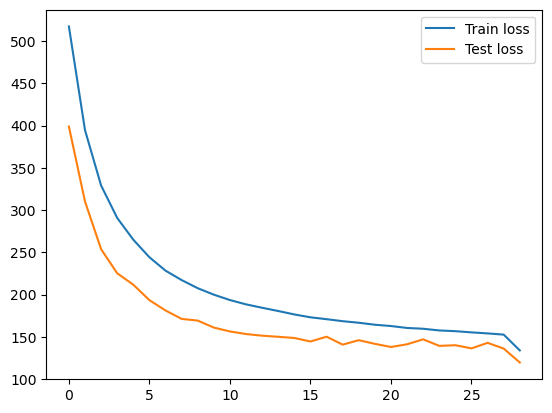

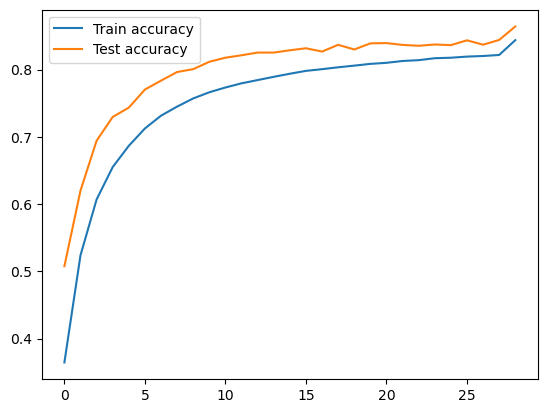

Epoch 2/10, Iteration: 0/2334, Training loss: 125.957, Accuracy: 0.857
Epoch 2/10, Iteration: 10/2334, Training loss: 123.642, Accuracy: 0.857
Epoch 2/10, Iteration: 20/2334, Training loss: 123.514, Accuracy: 0.860
Epoch 2/10, Iteration: 30/2334, Training loss: 124.375, Accuracy: 0.858
Epoch 2/10, Iteration: 40/2334, Training loss: 124.483, Accuracy: 0.856
Epoch 2/10, Iteration: 50/2334, Training loss: 125.274, Accuracy: 0.855
Epoch 2/10, Iteration: 60/2334, Training loss: 125.871, Accuracy: 0.853
Epoch 2/10, Iteration: 70/2334, Training loss: 125.792, Accuracy: 0.854
Epoch 2/10, Iteration: 80/2334, Training loss: 126.348, Accuracy: 0.853
Epoch 2/10, Iteration: 90/2334, Training loss: 125.976, Accuracy: 0.853
Epoch 2/10, Iteration: 100/2334, Training loss: 125.900, Accuracy: 0.853
Epoch 2/10, Iteration: 110/2334, Training loss: 126.567, Accuracy: 0.852
Epoch 2/10, Iteration: 120/2334, Training loss: 126.676, Accuracy: 0.852
Epoch 2/10, Iteration: 130/2334, Training loss: 127.070, Accur

Epoch 2/10, Iteration: 1130/2334, Training loss: 126.533, Accuracy: 0.852
Epoch 2/10, Iteration: 1140/2334, Training loss: 126.528, Accuracy: 0.852
Epoch 2/10, Iteration: 1150/2334, Training loss: 126.544, Accuracy: 0.852
Epoch 2/10, Iteration: 1160/2334, Training loss: 126.535, Accuracy: 0.852
Epoch 2/10, Iteration: 1170/2334, Training loss: 126.496, Accuracy: 0.852
Epoch 2/10, Iteration: 1180/2334, Training loss: 126.472, Accuracy: 0.852
Epoch 2/10, Iteration: 1190/2334, Training loss: 126.385, Accuracy: 0.852
Epoch 2/10, Iteration: 1200/2334, Training loss: 126.397, Accuracy: 0.852
Epoch 2/10, Iteration: 1210/2334, Training loss: 126.382, Accuracy: 0.852
Epoch 2/10, Iteration: 1220/2334, Training loss: 126.382, Accuracy: 0.852
Epoch 2/10, Iteration: 1230/2334, Training loss: 126.411, Accuracy: 0.852
Epoch 2/10, Iteration: 1240/2334, Training loss: 126.449, Accuracy: 0.852
Epoch 2/10, Iteration: 1250/2334, Training loss: 126.416, Accuracy: 0.852
Epoch 2/10, Iteration: 1260/2334, Trai

Epoch 2/10, Iteration: 2240/2334, Training loss: 125.667, Accuracy: 0.853
Epoch 2/10, Iteration: 2250/2334, Training loss: 125.682, Accuracy: 0.853
Epoch 2/10, Iteration: 2260/2334, Training loss: 125.690, Accuracy: 0.853
Epoch 2/10, Iteration: 2270/2334, Training loss: 125.674, Accuracy: 0.853
Epoch 2/10, Iteration: 2280/2334, Training loss: 125.679, Accuracy: 0.853
Epoch 2/10, Iteration: 2290/2334, Training loss: 125.676, Accuracy: 0.853
Epoch 2/10, Iteration: 2300/2334, Training loss: 125.666, Accuracy: 0.853
Epoch 2/10, Iteration: 2310/2334, Training loss: 125.642, Accuracy: 0.853
Epoch 2/10, Iteration: 2320/2334, Training loss: 125.644, Accuracy: 0.853
Epoch 2/10, Iteration: 2330/2334, Training loss: 125.641, Accuracy: 0.853
Epoch 2/10, Iteration: 0/34, Test loss: 144.058, Accuracy: 0.840
Epoch 2/10, Iteration: 1/34, Test loss: 118.225, Accuracy: 0.865
Epoch 2/10, Iteration: 2/34, Test loss: 125.276, Accuracy: 0.863
Epoch 2/10, Iteration: 3/34, Test loss: 122.597, Accuracy: 0.868


Epoch 3/10, Iteration: 720/2334, Training loss: 121.475, Accuracy: 0.857
Epoch 3/10, Iteration: 730/2334, Training loss: 121.533, Accuracy: 0.857
Epoch 3/10, Iteration: 740/2334, Training loss: 121.412, Accuracy: 0.857
Epoch 3/10, Iteration: 750/2334, Training loss: 121.494, Accuracy: 0.857
Epoch 3/10, Iteration: 760/2334, Training loss: 121.547, Accuracy: 0.857
Epoch 3/10, Iteration: 770/2334, Training loss: 121.486, Accuracy: 0.857
Epoch 3/10, Iteration: 780/2334, Training loss: 121.535, Accuracy: 0.857
Epoch 3/10, Iteration: 790/2334, Training loss: 121.677, Accuracy: 0.857
Epoch 3/10, Iteration: 800/2334, Training loss: 121.698, Accuracy: 0.857
Epoch 3/10, Iteration: 810/2334, Training loss: 121.648, Accuracy: 0.857
Epoch 3/10, Iteration: 820/2334, Training loss: 121.605, Accuracy: 0.857
Epoch 3/10, Iteration: 830/2334, Training loss: 121.666, Accuracy: 0.857
Epoch 3/10, Iteration: 840/2334, Training loss: 121.570, Accuracy: 0.857
Epoch 3/10, Iteration: 850/2334, Training loss: 121

Epoch 3/10, Iteration: 1840/2334, Training loss: 121.612, Accuracy: 0.857
Epoch 3/10, Iteration: 1850/2334, Training loss: 121.636, Accuracy: 0.857
Epoch 3/10, Iteration: 1860/2334, Training loss: 121.653, Accuracy: 0.857
Epoch 3/10, Iteration: 1870/2334, Training loss: 121.634, Accuracy: 0.857
Epoch 3/10, Iteration: 1880/2334, Training loss: 121.649, Accuracy: 0.857
Epoch 3/10, Iteration: 1890/2334, Training loss: 121.630, Accuracy: 0.857
Epoch 3/10, Iteration: 1900/2334, Training loss: 121.612, Accuracy: 0.857
Epoch 3/10, Iteration: 1910/2334, Training loss: 121.600, Accuracy: 0.858
Epoch 3/10, Iteration: 1920/2334, Training loss: 121.606, Accuracy: 0.857
Epoch 3/10, Iteration: 1930/2334, Training loss: 121.598, Accuracy: 0.857
Epoch 3/10, Iteration: 1940/2334, Training loss: 121.605, Accuracy: 0.857
Epoch 3/10, Iteration: 1950/2334, Training loss: 121.587, Accuracy: 0.858
Epoch 3/10, Iteration: 1960/2334, Training loss: 121.582, Accuracy: 0.857
Epoch 3/10, Iteration: 1970/2334, Trai

Epoch 4/10, Iteration: 320/2334, Training loss: 118.486, Accuracy: 0.861
Epoch 4/10, Iteration: 330/2334, Training loss: 118.378, Accuracy: 0.861
Epoch 4/10, Iteration: 340/2334, Training loss: 118.347, Accuracy: 0.861
Epoch 4/10, Iteration: 350/2334, Training loss: 118.412, Accuracy: 0.861
Epoch 4/10, Iteration: 360/2334, Training loss: 118.410, Accuracy: 0.861
Epoch 4/10, Iteration: 370/2334, Training loss: 118.466, Accuracy: 0.861
Epoch 4/10, Iteration: 380/2334, Training loss: 118.482, Accuracy: 0.861
Epoch 4/10, Iteration: 390/2334, Training loss: 118.270, Accuracy: 0.862
Epoch 4/10, Iteration: 400/2334, Training loss: 118.319, Accuracy: 0.861
Epoch 4/10, Iteration: 410/2334, Training loss: 118.513, Accuracy: 0.861
Epoch 4/10, Iteration: 420/2334, Training loss: 118.509, Accuracy: 0.861
Epoch 4/10, Iteration: 430/2334, Training loss: 118.612, Accuracy: 0.861
Epoch 4/10, Iteration: 440/2334, Training loss: 118.425, Accuracy: 0.861
Epoch 4/10, Iteration: 450/2334, Training loss: 118

Epoch 4/10, Iteration: 1440/2334, Training loss: 118.841, Accuracy: 0.861
Epoch 4/10, Iteration: 1450/2334, Training loss: 118.869, Accuracy: 0.861
Epoch 4/10, Iteration: 1460/2334, Training loss: 118.869, Accuracy: 0.861
Epoch 4/10, Iteration: 1470/2334, Training loss: 118.877, Accuracy: 0.861
Epoch 4/10, Iteration: 1480/2334, Training loss: 118.819, Accuracy: 0.861
Epoch 4/10, Iteration: 1490/2334, Training loss: 118.761, Accuracy: 0.861
Epoch 4/10, Iteration: 1500/2334, Training loss: 118.757, Accuracy: 0.861
Epoch 4/10, Iteration: 1510/2334, Training loss: 118.798, Accuracy: 0.861
Epoch 4/10, Iteration: 1520/2334, Training loss: 118.796, Accuracy: 0.861
Epoch 4/10, Iteration: 1530/2334, Training loss: 118.811, Accuracy: 0.861
Epoch 4/10, Iteration: 1540/2334, Training loss: 118.812, Accuracy: 0.861
Epoch 4/10, Iteration: 1550/2334, Training loss: 118.854, Accuracy: 0.861
Epoch 4/10, Iteration: 1560/2334, Training loss: 118.856, Accuracy: 0.861
Epoch 4/10, Iteration: 1570/2334, Trai

Epoch 4/10, Iteration: 24/34, Test loss: 124.795, Accuracy: 0.865
Epoch 4/10, Iteration: 25/34, Test loss: 124.633, Accuracy: 0.865
Epoch 4/10, Iteration: 26/34, Test loss: 125.191, Accuracy: 0.864
Epoch 4/10, Iteration: 27/34, Test loss: 124.511, Accuracy: 0.864
Epoch 4/10, Iteration: 28/34, Test loss: 124.308, Accuracy: 0.864
Epoch 4/10, Iteration: 29/34, Test loss: 123.986, Accuracy: 0.864
Epoch 4/10, Iteration: 30/34, Test loss: 123.134, Accuracy: 0.865
Epoch 4/10, Iteration: 31/34, Test loss: 123.835, Accuracy: 0.864
Epoch 4/10, Iteration: 32/34, Test loss: 123.600, Accuracy: 0.863
Epoch 4/10, Iteration: 33/34, Test loss: 121.211, Accuracy: 0.863
Epoch 5/10, Iteration: 0/2334, Training loss: 102.399, Accuracy: 0.897
Epoch 5/10, Iteration: 10/2334, Training loss: 112.128, Accuracy: 0.865
Epoch 5/10, Iteration: 20/2334, Training loss: 112.726, Accuracy: 0.863
Epoch 5/10, Iteration: 30/2334, Training loss: 115.056, Accuracy: 0.861
Epoch 5/10, Iteration: 40/2334, Training loss: 115.82

Epoch 5/10, Iteration: 1040/2334, Training loss: 115.665, Accuracy: 0.864
Epoch 5/10, Iteration: 1050/2334, Training loss: 115.623, Accuracy: 0.865
Epoch 5/10, Iteration: 1060/2334, Training loss: 115.672, Accuracy: 0.864
Epoch 5/10, Iteration: 1070/2334, Training loss: 115.615, Accuracy: 0.865
Epoch 5/10, Iteration: 1080/2334, Training loss: 115.617, Accuracy: 0.865
Epoch 5/10, Iteration: 1090/2334, Training loss: 115.593, Accuracy: 0.865
Epoch 5/10, Iteration: 1100/2334, Training loss: 115.550, Accuracy: 0.865
Epoch 5/10, Iteration: 1110/2334, Training loss: 115.504, Accuracy: 0.865
Epoch 5/10, Iteration: 1120/2334, Training loss: 115.497, Accuracy: 0.865
Epoch 5/10, Iteration: 1130/2334, Training loss: 115.531, Accuracy: 0.865
Epoch 5/10, Iteration: 1140/2334, Training loss: 115.492, Accuracy: 0.865
Epoch 5/10, Iteration: 1150/2334, Training loss: 115.507, Accuracy: 0.865
Epoch 5/10, Iteration: 1160/2334, Training loss: 115.552, Accuracy: 0.865
Epoch 5/10, Iteration: 1170/2334, Trai

Epoch 5/10, Iteration: 2150/2334, Training loss: 115.890, Accuracy: 0.864
Epoch 5/10, Iteration: 2160/2334, Training loss: 115.866, Accuracy: 0.865
Epoch 5/10, Iteration: 2170/2334, Training loss: 115.848, Accuracy: 0.865
Epoch 5/10, Iteration: 2180/2334, Training loss: 115.834, Accuracy: 0.865
Epoch 5/10, Iteration: 2190/2334, Training loss: 115.805, Accuracy: 0.865
Epoch 5/10, Iteration: 2200/2334, Training loss: 115.818, Accuracy: 0.865
Epoch 5/10, Iteration: 2210/2334, Training loss: 115.811, Accuracy: 0.865
Epoch 5/10, Iteration: 2220/2334, Training loss: 115.792, Accuracy: 0.865
Epoch 5/10, Iteration: 2230/2334, Training loss: 115.796, Accuracy: 0.865
Epoch 5/10, Iteration: 2240/2334, Training loss: 115.786, Accuracy: 0.865
Epoch 5/10, Iteration: 2250/2334, Training loss: 115.746, Accuracy: 0.865
Epoch 5/10, Iteration: 2260/2334, Training loss: 115.712, Accuracy: 0.865
Epoch 5/10, Iteration: 2270/2334, Training loss: 115.745, Accuracy: 0.865
Epoch 5/10, Iteration: 2280/2334, Trai

KeyboardInterrupt: 

In [107]:
# training loop
num_epochs = 10
for epoch in range(num_epochs):
  epoch_train(model, num_epochs, epoch, train_loader, loss_fn, optimizer)
  epoch_test(model, num_epochs, epoch, test_loader, loss_fn)
  torch.save(model.state_dict(), "./mini_mobile_net.pt")
  torch.save(train_losses, "./train_losses.pt")
  torch.save(test_losses, "./test_losses.pt")
  torch.save(train_accuracy, "./train_accuracy.pt")
  torch.save(test_accuracy, "./test_accuracy.pt")
  if epoch % 9 == 0:
    make_plot(train_losses, test_losses, "Train loss", "Test loss")
    make_plot(train_accuracy, test_accuracy, "Train accuracy","Test accuracy")
    

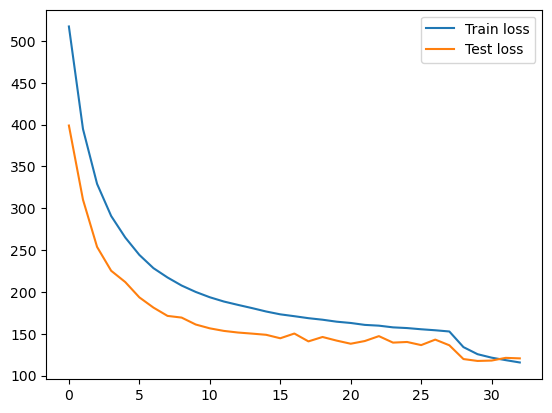

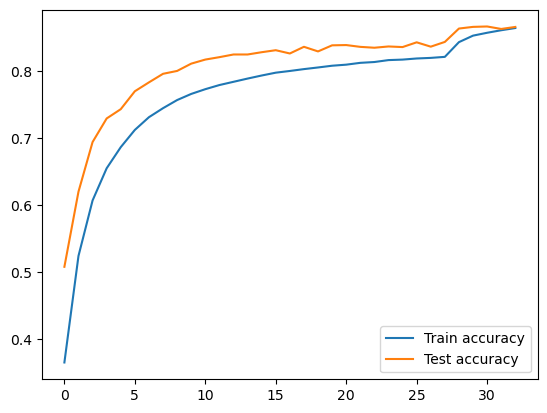

In [108]:
make_plot(train_losses, test_losses, "Train loss", "Test loss")
make_plot(train_accuracy, test_accuracy, "Train accuracy", "Test accuracy")